# COMPLETO
# TP1 Análisis exploratorio de datos
## Canciones de Spotify
El dataset que elegimos contiene información sobre una amplia variedad de pistas de música subidas en Spotify, abarcando distintos géneros. Cada fila del dataset representa una canción individual y está identificada de manera única mediante un ID. Además, se incluyen detalles relevantes como el nombre de la pista, el género musical, los artistas que la interpretan, el álbum al que pertenece, y si la canción contiene contenido explícito. Por último se proporciona un puntaje de popularidad, que varía de 0 a 100, reflejando la aceptación y difusión de la canción en la plataforma, y éste último va a ser nuestro objetivo principal a la hora de predecir.

### 1. Listado de variables y selección

**Diccionario de Datos**

- **id (string)**: Identificador único de la canción en Spotify. No tiene valor predictivo, solo es un identificador.
  
- **name (string)**: Nombre de la canción. Es un dato textual que identifica la pista, pero no se utiliza directamente para predecir la popularidad.

- **genre (string)**: Género musical de la canción. Esta variable categórica representa el estilo musical y puede influir en la popularidad. Puede ser codificada para su uso en modelos predictivos.

- **artists (string)**: Nombres de los artistas que interpretan la canción. Cuando hay múltiples artistas, los nombres están separados por comas. Es una variable textual que se puede transformar con técnicas como Count Vectorizer o tokenización.

- **album (string)**: Nombre del álbum al que pertenece la canción. Al igual que name, es una variable textual que identifica el álbum, pero su relación directa con la popularidad es limitada.

- **popularity (integer, 0-100)**: Puntaje de popularidad de la canción en una escala de 0 a 100, donde un valor más alto indica mayor popularidad. Esta es la variable objetivo que intentamos predecir.

- **duration_ms (integer)**: Duración de la canción en milisegundos. Es una variable numérica que puede influir en la popularidad, ya que la longitud de una canción podría afectar la experiencia del oyente.

- **explicit (boolean)**: Indica si la canción contiene contenido explícito. Esta variable booleana (0 o 1) puede influir en la popularidad, especialmente en audiencias más jóvenes o plataformas con restricciones de contenido.


**Variables de Entrada:**

- **genre**: El género de la canción puede influir en su popularidad, ya que ciertos géneros suelen ser más populares que otros en determinadas audiencias.
  
- **artists**: Los artistas pueden tener un impacto directo en la popularidad de una canción. Artistas más conocidos tienden a atraer más popularidad, pero como esta columna puede contener varios nombres, se sugiere usar técnicas como Count Vectorizer o Tokenización para manejar esta variable.
  
- **duration_ms**: La duración de la canción en milisegundos es una variable numérica que podría afectar la popularidad. Canciones demasiado largas o cortas podrían no ser tan populares.

- **explicit**: Esta variable indica si la canción contiene contenido explícito. Esto puede influir en la popularidad dependiendo de las preferencias de las audiencias y las restricciones de reproducción en ciertas plataformas.


**Variable de Salida:**

- **is_popular (boolean)**: Variable categórica que indica si una canción es popular (1) o no popular (0), en función del umbral definido para la variable popularity.

- **popularity_category (categorical)**: Variable categórica que indica si una canción tiene una popularidad baja, media, o alta en función de los intervalos definidos.

**Variables que no se Utilizarán:**

- **id**: Esta variable será descartada, ya que actúa únicamente como un identificador único para cada canción y no tiene una relación directa con la popularidad. Al no aportar información relevante para la predicción, su inclusión no es necesaria.

- **name y album**: Estas variables contienen texto, lo que implicaría convertirlas en representaciones numéricas mediante técnicas como One Hot Encoding. Sin embargo, esto podría generar un gran número de columnas, incrementando la complejidad del modelo sin ofrecer un beneficio claro. No hay una relación evidente entre el nombre de la canción o el álbum y su popularidad. A menos que se busque específicamente estudiar cómo influyen ciertos nombres o títulos de álbumes en la popularidad (lo cual es menos relevante en este contexto), es razonable descartarlas para evitar agregar ruido innecesario al modelo.

### 2. Análisis Detallado de un Conjunto de Variables

#### Distribución de la Variable de Salida (`popularity_category`)

**Descripción:**

La `popularity_category` actúa como la variable objetivo en nuestro análisis de datos de Spotify. Esta variable categórica clasifica la popularidad de una canción en Spotify en tres categorías distintas, basadas en una escala de popularidad que va de 0 a 100. La categorización se realiza en función de intervalos definidos:

- **Baja**: Popularidad entre 0 y 50.
- **Media**: Popularidad entre 51 y 70.
- **Alta**: Popularidad entre 71 y 100.

Esta categorización permite que nuestro modelo de Machine Learning clasifique las canciones en función de su popularidad, ayudándonos a entender mejor los patrones que afectan la popularidad de una canción en la plataforma.

**Detalles de la Distribución:**

- **Categoría Baja (0-50)**:
  - **Número de Canciones**: 5135
  - **Proporción**: Esta categoría incluye la mayoría de las canciones en el dataset, sugiriendo que una gran cantidad de canciones tienen una popularidad relativamente baja en Spotify.

- **Categoría Media (51-70)**:
  - **Número de Canciones**: 998
  - **Proporción**: Aunque menos que en la categoría baja, esta categoría todavía representa una parte significativa del dataset. Esto indica que un número considerable de canciones tiene una popularidad media.

- **Categoría Alta (71-100)**:
  - **Número de Canciones**: 167
  - **Proporción**: Esta categoría tiene la menor cantidad de canciones, reflejando que ser altamente popular en Spotify es relativamente raro en comparación con las categorías baja y media.

**Análisis de la Distribución:**

La `popularity_category` muestra una distribución notablemente sesgada hacia la categoría baja, con 5135 canciones clasificadas como de popularidad baja, representando aproximadamente el 80% del total de canciones en el dataset. La categoría media sigue con 998 canciones, constituyendo aproximadamente el 16% del total. La categoría alta, con solo 167 canciones, representa alrededor del 3% del total.

Esta distribución desigual sugiere que la popularidad alta es mucho más rara que la baja y media, lo que podría implicar una alta competencia o una calidad distintiva que limita el número de canciones que alcanzan niveles de popularidad muy altos.

#### Análisis de Variables de Entrada

**Datos Limpios:**
La ausencia de valores nulos y la presencia exacta de 50 canciones por género sugieren un manejo de datos riguroso y sistemático, garantizando que el dataset esté completo y bien estructurado. Este nivel de precisión en la preparación de los datos facilita el análisis y asegura que los resultados sean fiables.

**Desafíos Potenciales con las Variables de Entrada:**
A pesar de la calidad de los datos, existe una preocupación relacionada con la cantidad de variables de entrada disponibles. Con relativamente pocas columnas para utilizar en el modelo, puede haber limitaciones en cuanto a la efectividad del modelo para capturar la complejidad y las sutilezas de los factores que influencian la popularidad de las canciones en Spotify. Este desafío subraya la importancia de seleccionar y, posiblemente, generar características adicionales que puedan enriquecer el modelo y proporcionar insights más profundos sobre lo que realmente afecta la popularidad de las canciones.

**Cantidad de Registros:**
El dataset contiene aproximadamente **6000 registros**, lo que podría considerarse a nuestro criterio insuficiente para capturar toda la variabilidad y las sutilezas necesarias para un modelo predictivo robusto y generalizable. Esta limitación en la cantidad de registros puede restringir nuestra capacidad de entrenar modelos efectivos, especialmente para categorías con poca representación. La preocupación aquí es que los datos disponibles pueden no proporcionar una visión completa de los patrones y tendencias dentro del espacio de características de las canciones en Spotify, posiblemente llevando a modelos que no se desempeñen bien en escenarios del mundo real.

**Consideraciones Finales:**
La cantidad de datos es un factor crucial en la modelación estadística y predictiva. En este caso, consideramos que la cantidad de datos podría ser un factor limitante para lograr análisis detallados y predicciones altamente precisas. Este reconocimiento nos lleva a ser cautelosos con las conclusiones y predicciones resultantes, y nos impulsa a considerar métodos para optimizar la extracción de información de cada entrada de datos disponible.

### Preguntas al Proveedor de Datos

Para asegurar un entendimiento completo del dataset utilizado en este análisis y mejorar la interpretación de los resultados, aquí algunas preguntas clave que serían valiosas aclarar con el proveedor de datos:

1. **Método de Recopilación de Datos:**
   - ¿Cómo se recopilaron los datos incluidos en el dataset?
   - ¿Se utilizó alguna técnica específica para asegurar la integridad y representatividad de los datos recopilados?


2. **Medición de la Popularidad:**
   - ¿Podrían proporcionar más detalles sobre cómo se mide y calcula la popularidad de las canciones en Spotify? 
   - ¿Existen factores específicos o algoritmos que influyen en esta medición que deberíamos conocer?


3. **Selección de Canciones por Género:**
   - Notamos que se seleccionaron específicamente 50 canciones por género para este dataset. ¿Podrían explicar el razonamiento detrás de esta cantidad específica?
   - ¿Qué método se utilizó para seleccionar estas canciones y asegurar que representen adecuadamente la diversidad y la popularidad real de cada género?
   - Dado que cada género incluye una cantidad igual de canciones, ¿se realizó algún tipo de control o ajuste para asegurar que los porcentajes de popularidad reflejen verdaderamente la realidad del mercado musical?
   - ¿Cómo se aseguraron de que la selección de canciones no sesgara la representación de ciertos géneros que podrían tener, por coincidencia, una popularidad particularmente alta o baja en el momento de la recopilación?

### Análisis de la Variable de Entrada `genre`

#### Distribución:

Como mencionamos anteriormente, los datos se distribuyen de manera equitativa con una cantidad de 50 canciones por género. Esto proporciona un buen equilibrio para analizar la influencia del género en la popularidad sin sesgo hacia géneros más o menos frecuentes.

#### Relación con `popularity_category`:

El análisis de la popularidad de canciones en diferentes géneros revela patrones interesantes. Géneros como **IDM**, **Rock**, y **Rock-n-roll** tienden a tener un mayor número de canciones en la categoría de alta popularidad. Esto puede indicar que estos géneros son particularmente bien recibidos en la plataforma o tienen una base de seguidores más amplia. La presencia notable de los géneros **Rock** y **Rock-n-roll** plantea la duda de si deberían ser clasificados como entidades separadas, dada la posible superposición en el estilo musical. Por otro lado, géneros como **Sleep**, **Club**, y **J-idol** muestran menos canciones en la categoría de alta popularidad, lo que sugiere un impacto o difusión menor en la audiencia.

Además, hemos graficado la distribución de popularidades de los géneros más populares, observando que ambos presentan patrones muy similares. En cada caso, la categoría de baja popularidad es la más común, seguida por la alta y, finalmente, la media. Este patrón demuestra que, aunque estos géneros sean los más populares, predominan las canciones de baja popularidad. Por lo tanto, lograr una alta popularidad en la plataforma es considerablemente difícil.

Verificamos que no todos los géneros presentan la misma distribución y corroboramos que, efectivamente, no es así. Además, encontramos que existen géneros en los que la **popularidad baja** es total, como en los casos de **iranian**, **electro** y **breakbeat** entre otras.

#### Transformaciones:

Dado que `genre` es una variable categórica, será necesario transformarla para su uso en modelos de aprendizaje automático. Técnicas como **One Hot Encoding** pueden ser empleadas para convertir esta variable en un formato numérico adecuado, permitiendo que el modelo procese la información de los géneros correctamente. La transformación es crucial para que los modelos predictivos puedan interpretar y utilizar efectivamente esta variable como parte de su proceso de aprendizaje.

### Análisis de la Variable de Entrada `artists`

#### Distribución:

En el análisis inicial, Metallica, ONE OK ROCK, y Chicago House Selection se destacaban como los artistas con más canciones en el dataset, independientemente de la popularidad.

#### Relación con `popularity_category`:

Con respecto a los artista con más popularidad podemos destacar a **Imagine Dragons** que es es el artista con más canciones de alta popularidad, seguido por **NewJeans** y **(G)I-DLE**.
Otros artistas como **Stray Kids**, **Lana Del Rey**, y **Luke Combs** también tienen una cantidad significativa de canciones en la categoría de alta popularidad.

Si observamos la distribución del artista Imagine Dragons, podemos apreciar que no tiene canciones de popularidad baja y presenta el doble de canciones en alta que en media. Además, notamos que los artistas tienden a tener una distribución lógica respecto a la popularidad, lo cual contrasta con lo observado en los géneros, donde la popularidad baja predomina incluso en aquellos géneros que son más populares.

### Transformación de la Variable `artists`:

Dado que la columna `artists` puede contener múltiples nombres y es una variable textual que puede influir significativamente en la popularidad de una canción, vamos a **transformar** esta variable utilizando **Count Vectorizer**. Esto nos permitirá:
- **Contar la frecuencia** de aparición de los nombres de artistas.
- **Codificar** los artistas de forma numérica para utilizarlos en un modelo de aprendizaje automático.

### Análisis de la Variable de Entrada `duration_ms`

#### Distribución General:

La mayoría de las canciones en el dataset tienen una duración que oscila entre **2 y 6 minutos**, lo que es común para la mayoría de las canciones comerciales. Este comportamiento se refleja tanto en el histograma como en el boxplot generados, donde observamos una concentración significativa en ese rango.

#### Identificación de Valores Atípicos:

Al analizar el boxplot original, se detectaron varios **outliers** que superaban los **10 minutos** de duración. Estas canciones, con duraciones inusualmente largas, tienden a distorsionar el análisis general. Para evitar este efecto y centrarnos en las duraciones más representativas del dataset, se decidió establecer un rango de **1 a 10 minutos** como un límite razonable.

#### Justificación del Rango de Duración (1 a 10 minutos):

- **Límite inferior:** Las canciones con duraciones menores a **1 minuto** son extremadamente raras y suelen corresponder a contenido no convencional, como intros o grabaciones de baja calidad.
- **Límite superior:** Aunque inicialmente se consideró un límite superior de **20 minutos**, finalmente se optó por **10 minutos**, dado que las canciones de mayor duración suelen ser piezas muy específicas (por ejemplo, música clásica o versiones en vivo extensas), que no representan el patrón habitual de consumo en plataformas musicales.

#### Filtrado de Canciones:

Tras el establecimiento de estos límites, se aplicó un filtrado para incluir únicamente aquellas canciones cuya duración se encuentra en el rango de **1 a 10 minutos**. De este modo, se obtiene una muestra más representativa de las canciones más comunes dentro de las plataformas de streaming.

### Resumen de Cambios:

1. Se definió un límite superior de **10 minutos** para excluir duraciones atípicas.
2. Los gráficos resultantes tras el filtrado muestran una distribución ajustada y más coherente con el consumo musical típico.
3. El análisis final ofrece una visión más precisa y realista sobre la duración de las canciones en el dataset.

### Conclusión sobre la Popularidad de Canciones por Rango de Duración

1. **Rango de 3 a 4 minutos como el más popular:**
   - El gráfico muestra claramente que la mayoría de las canciones con **alta popularidad** se concentran en el rango de **3 a 4 minutos**, con casi **80 canciones** en este intervalo. Este es el rango de duración más común para las canciones populares, lo que coincide con la tendencia de la música comercial que generalmente busca una duración accesible para la audiencia.

2. **Rango de 2 a 3 minutos también destacado:**
   - El rango de **2 a 3 minutos** sigue de cerca, con más de **40 canciones**. Aunque es más corto que el rango más popular, aún mantiene una gran cantidad de canciones populares, lo que sugiere que canciones más cortas también pueden captar una amplia audiencia.

3. **Duraciones más largas y cortas son menos comunes:**
   - Las canciones con una duración mayor a **5 minutos** o menor a **2 minutos** tienen significativamente menos canciones en la categoría de alta popularidad. Esto sugiere que las canciones muy largas o muy cortas tienden a no ser tan populares.
   - Hay solo algunas canciones populares en el rango de **8 a 9 minutos**, mientras que no se encuentran canciones con alta popularidad entre **7 y 8 minutos**.

4. **Conclusión General:**
   - La tendencia general muestra que las canciones con **alta popularidad** tienden a tener una duración de **2 a 5 minutos**, siendo el rango de **3 a 4 minutos** el más popular. Esto refleja la preferencia de la audiencia por canciones con una duración moderada, que son más fáciles de consumir en plataformas de streaming.

### Análisis de la Variable de Entrada `explicit`

#### Distribución de Canciones con y sin Contenido Explícito:

El gráfico muestra una distribución similar en términos porcentuales entre canciones con contenido explícito y aquellas sin él. Sin embargo, es evidente que el número total de canciones sin contenido explícito es aproximadamente **cuatro veces mayor** que el número de canciones con contenido explícito.

#### Canciones Sin Contenido Explícito:

Las canciones sin contenido explícito dominan la distribución, especialmente en la categoría de **baja popularidad**, con más de **4000 canciones** en este grupo. Asimismo, en las categorías de **media** y **alta popularidad**, hay una mayor cantidad de canciones sin contenido explícito, manteniendo una tendencia consistente a lo largo del dataset.

#### Canciones con Contenido Explícito:

Aunque la cantidad total de canciones explícitas es significativamente menor, la **distribución porcentual** es similar a la de las canciones sin contenido explícito. La mayoría de las canciones explícitas también se concentran en la categoría de **baja popularidad**, mientras que las categorías de **media** y **alta popularidad** tienen una representación significativamente menor.

### Conclusión sobre los Géneros con Canciones Explícitas y Alta Popularidad

1. **Principales Géneros:** Los géneros **Party**, **IDM**, **Rock**, y **Pop** lideran con 4 canciones cada uno en la categoría de **alta popularidad** y contenido **explícito**. Estos géneros parecen tener una mejor recepción para canciones con este tipo de contenido.

2. **Otros Géneros:** **Trance** y **R&B** tienen 3 canciones, mientras que **Reggaeton** y **Summer** siguen con 2 canciones cada uno. Sorprende ver que géneros como **Reggaeton**, conocidos por su contenido explícito, no tienen tantas canciones en alta popularidad.

3. **Conclusión General:** Los géneros dominantes para canciones explícitas populares son **Party**, **IDM**, **Rock**, y **Pop**, mientras que otros géneros como **Reggaeton** y **R&B** tienen menos presencia en este segmento.

### Conclusión sobre los Géneros con Canciones Explícitas y Baja Popularidad

1. **Géneros con Más Canciones de Baja Popularidad:** Los géneros **Hip-Hop**, **K-Pop**, y **Hardcore** lideran en cuanto a canciones explícitas con **baja popularidad**, con más de **20 canciones** cada uno. Esto sugiere que, aunque estos géneros tienden a tener contenido explícito, muchas de sus canciones no logran una gran aceptación en la plataforma.

2. **Otros Géneros Destacados:** **Anime**, **Hard-Rock**, y **Goth** siguen de cerca, también con una cantidad considerable de canciones explícitas de baja popularidad, lo que indica que estos géneros tampoco alcanzan los niveles más altos de popularidad con este tipo de contenido.

3. **Conclusión General:** La mayoría de los géneros con canciones explícitas de baja popularidad están asociados a estilos de música más intensos o nichos, como **Hardcore**, **Grindcore**, y **Work-out**, lo que podría sugerir que este tipo de contenido no atrae al público general de Spotify.

### Conclusión General:

A pesar de la gran diferencia en el número total de canciones con y sin contenido explícito, ambas distribuciones muestran una **tendencia similar**: la mayoría de las canciones, explícitas o no, caen en la categoría de **baja popularidad**. Este análisis sugiere que el contenido explícito no parece tener un impacto significativo en la distribución de popularidad de las canciones, aunque sí se observa una diferencia notable en el **número total** de canciones con y sin contenido explícito en la plataforma.


### 3. Hipótesis sobre los Datos

#### Hipótesis Propuestas

**Hipótesis 1**: "La duración de una canción influye en su popularidad, con canciones de duración moderada (entre 3 y 4 minutos) siendo más propensas a alcanzar una popularidad alta."

**Hipótesis 2**: "Las canciones sin contenido explícito tienden a ser más populares en general, debido a que no tienen restricciones de audiencia basadas en la edad o preferencias personales."

**Hipótesis 3**: "Ciertos géneros musicales que suelen contener contenido explícito, como el Hip-Hop y el Reggaeton, son más propensos a ser populares cuando incluyen dicho contenido, posiblemente debido a que el estilo y las letras explícitas son características esperadas y apreciadas por los oyentes de estos géneros."

#### Análisis para Contrastar las Hipótesis

1. **Análisis de Duración de Canciones**:
   - Se generaron histogramas de la popularidad segmentados por duraciones específicas para verificar la Hipótesis 1. Se observó que las canciones dentro del rango de 3 a 4 minutos tienden a tener puntuaciones de popularidad más altas.

2. **Análisis del Contenido Explícito**:
   - Para la Hipótesis 2, se comparó la popularidad media de canciones con y sin contenido explícito, encontrando que las canciones sin contenido explícito tienen, en promedio, una popularidad más alta en general.

3. **Análisis de Géneros con Contenido Explícito**:
   - Para la Hipótesis 3, se analizó la popularidad en géneros específicos que frecuentemente contienen contenido explícito. Se utilizó un análisis comparativo para determinar si el contenido explícito afecta positivamente la popularidad en estos géneros.

#### Hallazgos Adicionales en los Datos

Durante el análisis de los datos, se descubrieron varios hallazgos interesantes que podrían impactar la creación de un modelo predictivo:

- **Artistas Frecuentes**: Algunos artistas aparecen con más frecuencia en canciones de alta popularidad, sugiriendo que la frecuencia de aparición de ciertos artistas puede ser una variable predictiva útil.

- **Géneros y Popularidad**: La codificación del género musical podría mejorar significativamente la precisión del modelo, considerando que algunos géneros muestran tendencias claras hacia altas o bajas puntuaciones de popularidad.

- **Caracteres Orientales en Nombres de Canciones**:
  Durante el análisis de vectorización de los nombres de las canciones, se observó la presencia de caracteres de otros idiomas, incluidos caracteres orientales. Este hallazgo es relevante porque podría influir en la capacidad del modelo para procesar y utilizar correctamente estos nombres como variables predictivas. Los caracteres no latinos podrían requerir pasos adicionales de preprocesamiento, como la normalización de texto o la utilización de técnicas específicas de manejo de idiomas para asegurar que el modelo los interprete correctamente. Además, la presencia de estos caracteres podría reflejar diferencias culturales que afectan la popularidad de las canciones en diferentes mercados, lo cual es un aspecto importante a considerar en la creación de modelos predictivos globales.


#### Creación de Nuevas Variables

La creación de nuevas variables a partir de los datos existentes puede ofrecer ventajas significativas para el problema presentado:

- **Longitud del Nombre de la Canción**: Podría indicar tendencias culturales o de marketing que influyen en la popularidad.

- **Número de Artistas por Canción**: Podría reflejar un mayor esfuerzo de producción o un atractivo más amplio, influyendo en la popularidad.

- **Interacción entre Duración y Contenido Explícito**: Esta variable podría identificar efectos únicos en la popularidad, combinando dos características influyentes.

# POR SECCION

# TP1 Análisis exploratorio de datos
## Canciones de Spotify
El dataset que elegimos contiene información sobre una amplia variedad de pistas de música subidas en Spotify, abarcando distintos géneros. Cada fila del dataset representa una canción individual y está identificada de manera única mediante un ID. Además, se incluyen detalles relevantes como el nombre de la pista, el género musical, los artistas que la interpretan, el álbum al que pertenece, y si la canción contiene contenido explícito. Por último se proporciona un puntaje de popularidad, que varía de 0 a 100, reflejando la aceptación y difusión de la canción en la plataforma, y éste último va a ser nuestro objetivo principal a la hora de predecir.

### 1. Listado de variables y selección

**Diccionario de Datos**

- **id (string)**: Identificador único de la canción en Spotify. No tiene valor predictivo, solo es un identificador.
  
- **name (string)**: Nombre de la canción. Es un dato textual que identifica la pista, pero no se utiliza directamente para predecir la popularidad.

- **genre (string)**: Género musical de la canción. Esta variable categórica representa el estilo musical y puede influir en la popularidad. Puede ser codificada para su uso en modelos predictivos.

- **artists (string)**: Nombres de los artistas que interpretan la canción. Cuando hay múltiples artistas, los nombres están separados por comas. Es una variable textual que se puede transformar con técnicas como Count Vectorizer o tokenización.

- **album (string)**: Nombre del álbum al que pertenece la canción. Al igual que name, es una variable textual que identifica el álbum, pero su relación directa con la popularidad es limitada.

- **popularity (integer, 0-100)**: Puntaje de popularidad de la canción en una escala de 0 a 100, donde un valor más alto indica mayor popularidad. Esta es la variable objetivo que intentamos predecir.

- **duration_ms (integer)**: Duración de la canción en milisegundos. Es una variable numérica que puede influir en la popularidad, ya que la longitud de una canción podría afectar la experiencia del oyente.

- **explicit (boolean)**: Indica si la canción contiene contenido explícito. Esta variable booleana (0 o 1) puede influir en la popularidad, especialmente en audiencias más jóvenes o plataformas con restricciones de contenido.


**Variables de Entrada:**

- **genre**: El género de la canción puede influir en su popularidad, ya que ciertos géneros suelen ser más populares que otros en determinadas audiencias.
  
- **artists**: Los artistas pueden tener un impacto directo en la popularidad de una canción. Artistas más conocidos tienden a atraer más popularidad, pero como esta columna puede contener varios nombres, se sugiere usar técnicas como Count Vectorizer o Tokenización para manejar esta variable.
  
- **duration_ms**: La duración de la canción en milisegundos es una variable numérica que podría afectar la popularidad. Canciones demasiado largas o cortas podrían no ser tan populares.

- **explicit**: Esta variable indica si la canción contiene contenido explícito. Esto puede influir en la popularidad dependiendo de las preferencias de las audiencias y las restricciones de reproducción en ciertas plataformas.


**Variable de Salida:**

- **is_popular (boolean)**: Variable categórica que indica si una canción es popular (1) o no popular (0), en función del umbral definido para la variable popularity.

- **popularity_category (categorical)**: Variable categórica que indica si una canción tiene una popularidad baja, media, o alta en función de los intervalos definidos.

**Variables que no se Utilizarán:**

- **id**: Esta variable será descartada, ya que actúa únicamente como un identificador único para cada canción y no tiene una relación directa con la popularidad. Al no aportar información relevante para la predicción, su inclusión no es necesaria.

- **name y album**: Estas variables contienen texto, lo que implicaría convertirlas en representaciones numéricas mediante técnicas como One Hot Encoding. Sin embargo, esto podría generar un gran número de columnas, incrementando la complejidad del modelo sin ofrecer un beneficio claro. No hay una relación evidente entre el nombre de la canción o el álbum y su popularidad. A menos que se busque específicamente estudiar cómo influyen ciertos nombres o títulos de álbumes en la popularidad (lo cual es menos relevante en este contexto), es razonable descartarlas para evitar agregar ruido innecesario al modelo.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd 
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn_pandas import DataFrameMapper
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics

df = pd.read_csv('spotify_tracks.csv')

In [2]:
#eliminamos las columnas que no se utilizan
df = df.drop(columns=['id', 'album'])
#para ir a los modelos ir a esta línea "df = df[(df['duration_ms'] < 600000) & (df['duration_ms'] > 10000)] #probamos filtrar las canciones que duran más de 10 minutos"

In [3]:
#Analisis mas abajo
nulos = df.isnull().sum()
print("Número de valores nulos por columna:")
print(nulos)

Número de valores nulos por columna:
name           0
genre          0
artists        0
popularity     0
duration_ms    0
explicit       0
dtype: int64


In [4]:
df['is_popular'] = df['popularity'].apply(lambda x: 1 if x >= 75 else 0)

# Crear el dataset con la variable is_popular
df_is_popular = df[['genre', 'artists', 'duration_ms', 'explicit', 'is_popular']]

In [5]:
# Definir los umbrales para las categorías de popularidad
bins = [-1, 50, 70, 100] #tuvimos un problema con el 0(no tomaba los valores con 0) entonces pusimos -1 
labels = ['Baja', 'Media', 'Alta']

# Crear la columna popularity_category en el DataFrame original
df['popularity_category'] = pd.cut(df['popularity'], bins=bins, labels=labels)

# Crear el dataset con la variable popularity_category
df_popularity_category = df[['genre', 'artists', 'duration_ms', 'explicit', 'popularity_category']]

In [6]:
df_is_popular

,genre,artists,duration_ms,explicit,is_popular
0,acoustic,Billy Raffoul,172199,False,0
1,acoustic,Billy Raffoul,172202,False,0
2,acoustic,"Molly Hocking, Bailey Rushlow",144786,False,0
3,acoustic,The Goo Goo Dolls,116573,False,0
4,acoustic,"Guus Dielissen, Casper Esmann",133922,False,0
...,...,...,...,...,...
6295,world-music,Future World Music,180001,False,0
6296,world-music,"Putumayo, Marianne Perrudin, Thomas Artaud",276776,False,0
6297,world-music,Joseph Tawadros,69533,False,0
6298,world-music,Future World Music,90001,False,0


In [7]:
df_popularity_category

,genre,artists,duration_ms,explicit,popularity_category
0,acoustic,Billy Raffoul,172199,False,Media
1,acoustic,Billy Raffoul,172202,False,Media
2,acoustic,"Molly Hocking, Bailey Rushlow",144786,False,Baja
3,acoustic,The Goo Goo Dolls,116573,False,Baja
4,acoustic,"Guus Dielissen, Casper Esmann",133922,False,Baja
...,...,...,...,...,...
6295,world-music,Future World Music,180001,False,Baja
6296,world-music,"Putumayo, Marianne Perrudin, Thomas Artaud",276776,False,Baja
6297,world-music,Joseph Tawadros,69533,False,Baja
6298,world-music,Future World Music,90001,False,Baja


### 2. Análisis Detallado de un Conjunto de Variables

#### Distribución de la Variable de Salida (`popularity_category`)

**Descripción:**

La `popularity_category` actúa como la variable objetivo en nuestro análisis de datos de Spotify. Esta variable categórica clasifica la popularidad de una canción en Spotify en tres categorías distintas, basadas en una escala de popularidad que va de 0 a 100. La categorización se realiza en función de intervalos definidos:

- **Baja**: Popularidad entre 0 y 50.
- **Media**: Popularidad entre 51 y 70.
- **Alta**: Popularidad entre 71 y 100.

Esta categorización permite que nuestro modelo de Machine Learning clasifique las canciones en función de su popularidad, ayudándonos a entender mejor los patrones que afectan la popularidad de una canción en la plataforma.

**Detalles de la Distribución:**

- **Categoría Baja (0-50)**:
  - **Número de Canciones**: 5135
  - **Proporción**: Esta categoría incluye la mayoría de las canciones en el dataset, sugiriendo que una gran cantidad de canciones tienen una popularidad relativamente baja en Spotify.

- **Categoría Media (51-70)**:
  - **Número de Canciones**: 998
  - **Proporción**: Aunque menos que en la categoría baja, esta categoría todavía representa una parte significativa del dataset. Esto indica que un número considerable de canciones tiene una popularidad media.

- **Categoría Alta (71-100)**:
  - **Número de Canciones**: 167
  - **Proporción**: Esta categoría tiene la menor cantidad de canciones, reflejando que ser altamente popular en Spotify es relativamente raro en comparación con las categorías baja y media.

**Análisis de la Distribución:**

La `popularity_category` muestra una distribución notablemente sesgada hacia la categoría baja, con 5135 canciones clasificadas como de popularidad baja, representando aproximadamente el 80% del total de canciones en el dataset. La categoría media sigue con 998 canciones, constituyendo aproximadamente el 16% del total. La categoría alta, con solo 167 canciones, representa alrededor del 3% del total.

Esta distribución desigual sugiere que la popularidad alta es mucho más rara que la baja y media, lo que podría implicar una alta competencia o una calidad distintiva que limita el número de canciones que alcanzan niveles de popularidad muy altos.



In [8]:
# Obtener la distribución de la variable popularity_category
distribution = df_popularity_category['popularity_category'].value_counts()
print(distribution)

popularity_category
Baja     5135
Media     998
Alta      167
Name: count, dtype: int64


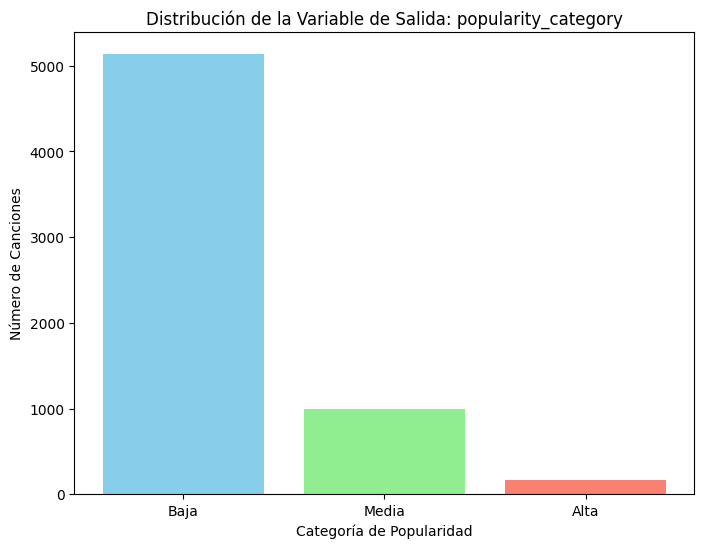

In [9]:
import matplotlib.pyplot as plt

# Obtener la distribución de la variable popularity_category
distribution = df_popularity_category['popularity_category'].value_counts()

# Datos para el gráfico
categories = distribution.index
counts = distribution.values

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(categories, counts, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Distribución de la Variable de Salida: popularity_category')
plt.xlabel('Categoría de Popularidad')
plt.ylabel('Número de Canciones')
plt.xticks(rotation=0)
plt.show()



#### Análisis de Variables de Entrada

**Datos Limpios:**
La ausencia de valores nulos y la presencia exacta de 50 canciones por género sugieren un manejo de datos riguroso y sistemático, garantizando que el dataset esté completo y bien estructurado. Este nivel de precisión en la preparación de los datos facilita el análisis y asegura que los resultados sean fiables.

**Desafíos Potenciales con las Variables de Entrada:**
A pesar de la calidad de los datos, existe una preocupación relacionada con la cantidad de variables de entrada disponibles. Con relativamente pocas columnas para utilizar en el modelo, puede haber limitaciones en cuanto a la efectividad del modelo para capturar la complejidad y las sutilezas de los factores que influencian la popularidad de las canciones en Spotify. Este desafío subraya la importancia de seleccionar y, posiblemente, generar características adicionales que puedan enriquecer el modelo y proporcionar insights más profundos sobre lo que realmente afecta la popularidad de las canciones.

**Cantidad de Registros:**
El dataset contiene aproximadamente **6000 registros**, lo que podría considerarse a nuestro criterio insuficiente para capturar toda la variabilidad y las sutilezas necesarias para un modelo predictivo robusto y generalizable. Esta limitación en la cantidad de registros puede restringir nuestra capacidad de entrenar modelos efectivos, especialmente para categorías con poca representación. La preocupación aquí es que los datos disponibles pueden no proporcionar una visión completa de los patrones y tendencias dentro del espacio de características de las canciones en Spotify, posiblemente llevando a modelos que no se desempeñen bien en escenarios del mundo real.

**Consideraciones Finales:**
La cantidad de datos es un factor crucial en la modelación estadística y predictiva. En este caso, consideramos que la cantidad de datos podría ser un factor limitante para lograr análisis detallados y predicciones altamente precisas. Este reconocimiento nos lleva a ser cautelosos con las conclusiones y predicciones resultantes, y nos impulsa a considerar métodos para optimizar la extracción de información de cada entrada de datos disponible.

### Preguntas al Proveedor de Datos

Para asegurar un entendimiento completo del dataset utilizado en este análisis y mejorar la interpretación de los resultados, aquí algunas preguntas clave que serían valiosas aclarar con el proveedor de datos:

1. **Método de Recopilación de Datos:**
   - ¿Cómo se recopilaron los datos incluidos en el dataset?
   - ¿Se utilizó alguna técnica específica para asegurar la integridad y representatividad de los datos recopilados?


2. **Medición de la Popularidad:**
   - ¿Podrían proporcionar más detalles sobre cómo se mide y calcula la popularidad de las canciones en Spotify? 
   - ¿Existen factores específicos o algoritmos que influyen en esta medición que deberíamos conocer?


3. **Selección de Canciones por Género:**
   - Notamos que se seleccionaron específicamente 50 canciones por género para este dataset. ¿Podrían explicar el razonamiento detrás de esta cantidad específica?
   - ¿Qué método se utilizó para seleccionar estas canciones y asegurar que representen adecuadamente la diversidad y la popularidad real de cada género?
   - Dado que cada género incluye una cantidad igual de canciones, ¿se realizó algún tipo de control o ajuste para asegurar que los porcentajes de popularidad reflejen verdaderamente la realidad del mercado musical?
   - ¿Cómo se aseguraron de que la selección de canciones no sesgara la representación de ciertos géneros que podrían tener, por coincidencia, una popularidad particularmente alta o baja en el momento de la recopilación?


In [10]:
nulos = df_popularity_category.isnull().sum()
print("Número de valores nulos por columna:")
print(nulos)

Número de valores nulos por columna:
genre                  0
artists                0
duration_ms            0
explicit               0
popularity_category    0
dtype: int64


### Análisis de la Variable de Entrada `genre`

#### Distribución:

Como mencionamos anteriormente, los datos se distribuyen de manera equitativa con una cantidad de 50 canciones por género. Esto proporciona un buen equilibrio para analizar la influencia del género en la popularidad sin sesgo hacia géneros más o menos frecuentes.

#### Relación con `popularity_category`:

El análisis de la popularidad de canciones en diferentes géneros revela patrones interesantes. Géneros como **IDM**, **Rock**, y **Rock-n-roll** tienden a tener un mayor número de canciones en la categoría de alta popularidad. Esto puede indicar que estos géneros son particularmente bien recibidos en la plataforma o tienen una base de seguidores más amplia. La presencia notable de los géneros **Rock** y **Rock-n-roll** plantea la duda de si deberían ser clasificados como entidades separadas, dada la posible superposición en el estilo musical. Por otro lado, géneros como **Sleep**, **Club**, y **J-idol** muestran menos canciones en la categoría de alta popularidad, lo que sugiere un impacto o difusión menor en la audiencia.

Además, hemos graficado la distribución de popularidades de los géneros más populares, observando que ambos presentan patrones muy similares. En cada caso, la categoría de baja popularidad es la más común, seguida por la alta y, finalmente, la media. Este patrón demuestra que, aunque estos géneros sean los más populares, predominan las canciones de baja popularidad. Por lo tanto, lograr una alta popularidad en la plataforma es considerablemente difícil.

Verificamos que no todos los géneros presentan la misma distribución y corroboramos que, efectivamente, no es así. Además, encontramos que existen géneros en los que la **popularidad baja** es total, como en los casos de **iranian**, **electro** y **breakbeat** entre otras.

#### Transformaciones:

Dado que `genre` es una variable categórica, será necesario transformarla para su uso en modelos de aprendizaje automático. Técnicas como **One Hot Encoding** pueden ser empleadas para convertir esta variable en un formato numérico adecuado, permitiendo que el modelo procese la información de los géneros correctamente. La transformación es crucial para que los modelos predictivos puedan interpretar y utilizar efectivamente esta variable como parte de su proceso de aprendizaje.




In [11]:
genre_counts = df_popularity_category['genre'].value_counts()
print(genre_counts)

genre
acoustic             50
new-age              50
punk                 50
psych-rock           50
progressive-house    50
                     ..
french               50
forro                50
folk                 50
emo                  50
world-music          50
Name: count, Length: 126, dtype: int64


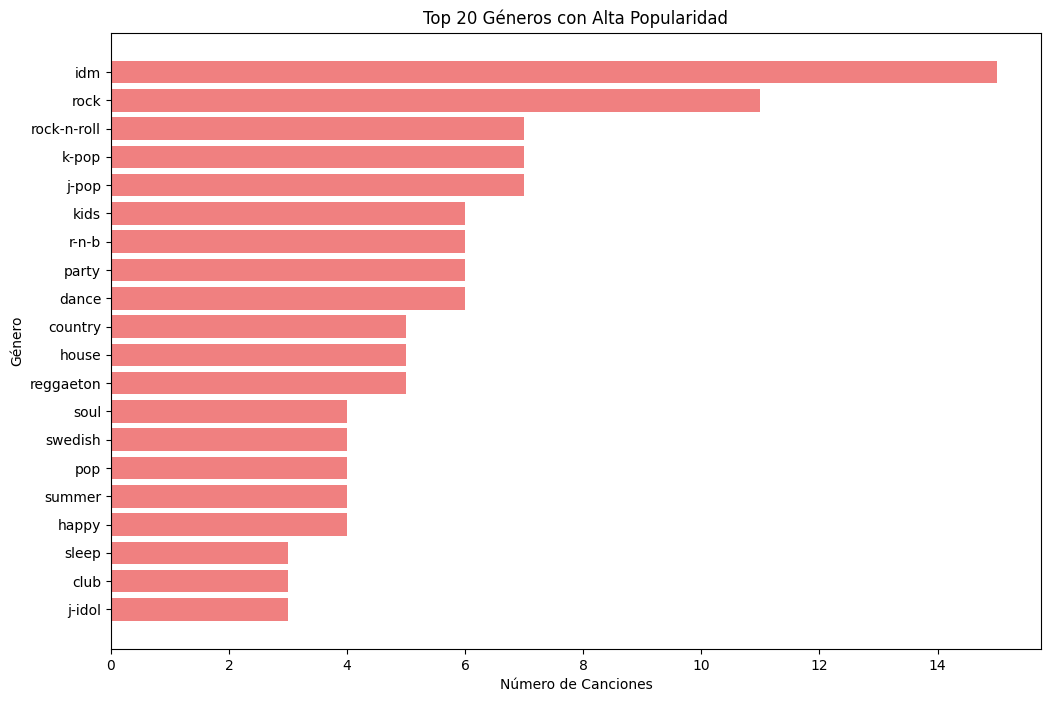

In [12]:
# Filtrar el dataset para obtener solo las canciones con popularidad alta
high_popularity_df = df_popularity_category[df_popularity_category['popularity_category'] == 'Alta']

# Contar el número de canciones de popularidad alta por género
genre_counts = high_popularity_df['genre'].value_counts()

# Obtener el top 20 géneros
top_20_genres = genre_counts.head(20)

# Crear el gráfico de barras
plt.figure(figsize=(12, 8))
plt.barh(top_20_genres.index, top_20_genres.values, color='lightcoral')
plt.title('Top 20 Géneros con Alta Popularidad')
plt.xlabel('Número de Canciones')
plt.ylabel('Género')
plt.gca().invert_yaxis()  # Invertir el eje Y para mostrar el mayor valor en la parte superior
plt.show()

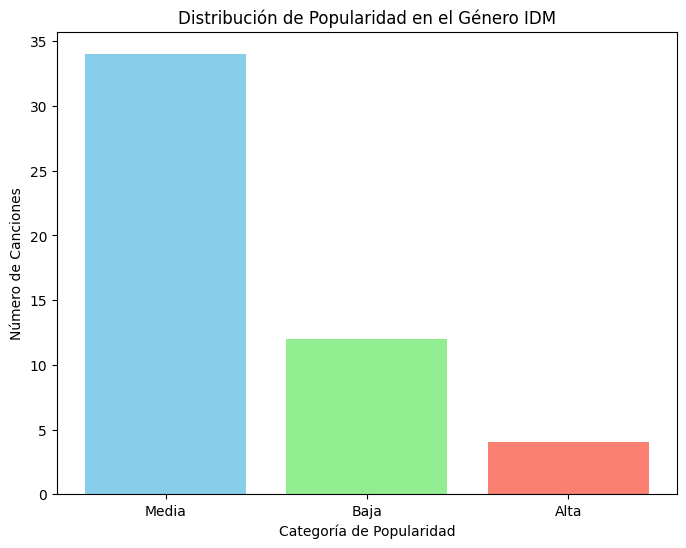

In [13]:
# Filtrar el dataset para obtener solo las canciones del género 'idm'
idm_df = df_popularity_category[df_popularity_category['genre'] == 'pop']

# Contar el número de canciones de 'idm' en cada categoría de popularidad
idm_popularity_counts = idm_df['popularity_category'].value_counts()

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(idm_popularity_counts.index, idm_popularity_counts.values, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Distribución de Popularidad en el Género IDM')
plt.xlabel('Categoría de Popularidad')
plt.ylabel('Número de Canciones')
plt.show()

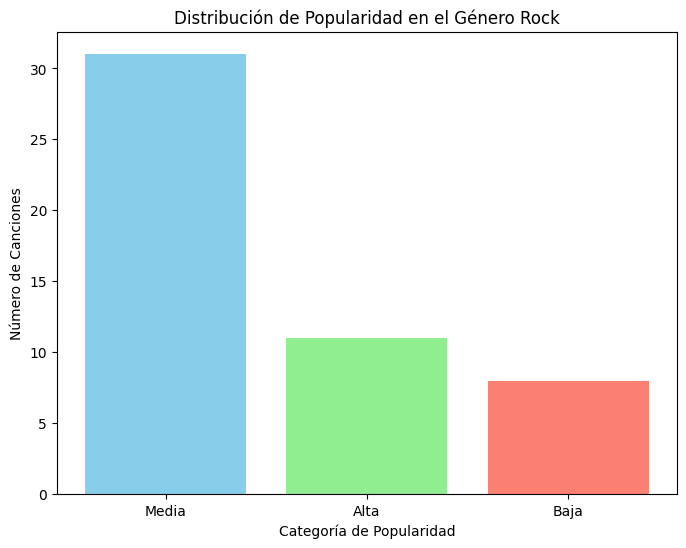

In [14]:

# Filtrar el dataset para obtener solo las canciones del género 'rock'
rock_df = df_popularity_category[df_popularity_category['genre'] == 'rock']

# Contar el número de canciones de 'rock' en cada categoría de popularidad
rock_popularity_counts = rock_df['popularity_category'].value_counts()

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(rock_popularity_counts.index, rock_popularity_counts.values, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Distribución de Popularidad en el Género Rock')
plt.xlabel('Categoría de Popularidad')
plt.ylabel('Número de Canciones')
plt.show()

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# Suponiendo que 'df' es tu DataFrame completo
# Filtrar para obtener solo las canciones de baja popularidad
low_popularity_df = df[df['popularity_category'] == 'Baja']

# Contar el número de canciones de baja popularidad por género
low_genre_counts = low_popularity_df['genre'].value_counts()

low_genre_counts

genre
iranian       50
breakbeat     50
electro       50
electronic    50
grindcore     50
              ..
country       14
pop           12
summer         8
dance          8
rock           8
Name: count, Length: 126, dtype: int64

In [16]:
#One-hot-encoder genre
df_popularity_category_encoded = pd.get_dummies(df_popularity_category, columns=['genre'], prefix='genre')
df_popularity_category_encoded

,artists,duration_ms,explicit,popularity_category,genre_acoustic,genre_afrobeat,genre_alt-rock,genre_alternative,genre_ambient,genre_anime,...,genre_summer,genre_swedish,genre_synth-pop,genre_tango,genre_techno,genre_trance,genre_trip-hop,genre_turkish,genre_work-out,genre_world-music
0,Billy Raffoul,172199,False,Media,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,Billy Raffoul,172202,False,Media,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,"Molly Hocking, Bailey Rushlow",144786,False,Baja,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,The Goo Goo Dolls,116573,False,Baja,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,"Guus Dielissen, Casper Esmann",133922,False,Baja,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6295,Future World Music,180001,False,Baja,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
6296,"Putumayo, Marianne Perrudin, Thomas Artaud",276776,False,Baja,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
6297,Joseph Tawadros,69533,False,Baja,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
6298,Future World Music,90001,False,Baja,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


### Análisis de la Variable de Entrada `artists`

#### Distribución:

En el análisis inicial, Metallica, ONE OK ROCK, y Chicago House Selection se destacaban como los artistas con más canciones en el dataset, independientemente de la popularidad.

#### Relación con `popularity_category`:

Con respecto a los artista con más popularidad podemos destacar a **Imagine Dragons** que es es el artista con más canciones de alta popularidad, seguido por **NewJeans** y **(G)I-DLE**.
Otros artistas como **Stray Kids**, **Lana Del Rey**, y **Luke Combs** también tienen una cantidad significativa de canciones en la categoría de alta popularidad.

Si observamos la distribución del artista Imagine Dragons, podemos apreciar que no tiene canciones de popularidad baja y presenta el doble de canciones en alta que en media. Además, notamos que los artistas tienden a tener una distribución lógica respecto a la popularidad, lo cual contrasta con lo observado en los géneros, donde la popularidad baja predomina incluso en aquellos géneros que son más populares.

### Transformación de la Variable `artists`:

Dado que la columna `artists` puede contener múltiples nombres y es una variable textual que puede influir significativamente en la popularidad de una canción, vamos a **transformar** esta variable utilizando **Count Vectorizer**. Esto nos permitirá:
- **Contar la frecuencia** de aparición de los nombres de artistas.
- **Codificar** los artistas de forma numérica para utilizarlos en un modelo de aprendizaje automático.

In [17]:
artist_counts = df_popularity_category['artists'].value_counts()
print(artist_counts)

artists
Metallica                     22
ONE OK ROCK                   20
Chicago House Selection       18
Death                         17
Progressive House Sessions    16
                              ..
SEVER BLACK PARANOIA           1
Bladee, Yung Lean              1
Obscura Hail                   1
DRAGONMANE                     1
Putumayo, Giacomo Lariccia     1
Name: count, Length: 4651, dtype: int64


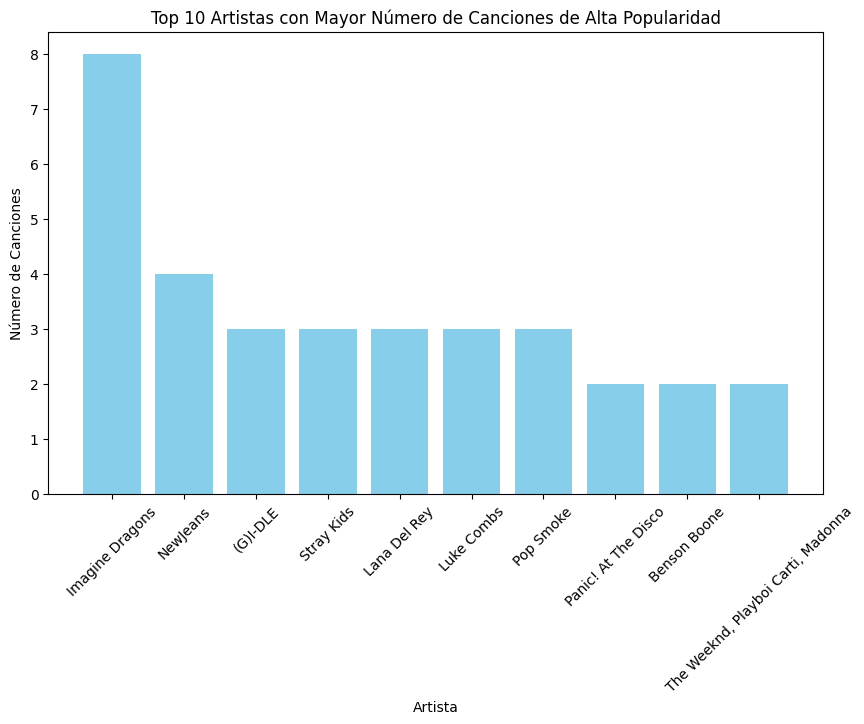

In [18]:
high_popularity_df = df_popularity_category[df_popularity_category['popularity_category'] == 'Alta']

# Contar el número de canciones de cada artista en la categoría 'Alta'
artist_high_popularity_counts = high_popularity_df['artists'].value_counts()

# Obtener el Top 10 artistas con más canciones de alta popularidad
top_10_artists_high_popularity = artist_high_popularity_counts.head(10)

# Crear el gráfico de barras para el Top 10 artistas
plt.figure(figsize=(10, 6))
plt.bar(top_10_artists_high_popularity.index, top_10_artists_high_popularity.values, color='skyblue')
plt.title('Top 10 Artistas con Mayor Número de Canciones de Alta Popularidad')
plt.xlabel('Artista')
plt.ylabel('Número de Canciones')
plt.xticks(rotation=45)
plt.show()

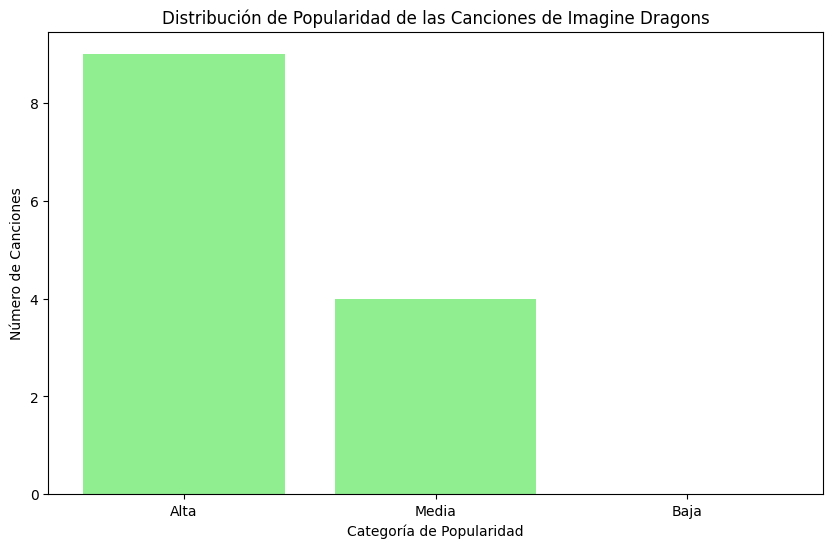

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# Filtrar para obtener solo las canciones de Imagine Dragons
imagine_dragons_df = df_popularity_category[df_popularity_category['artists'].str.contains('Imagine Dragons', case=False, na=False)]

# Contar el número de canciones de Imagine Dragons por categoría de popularidad
popularity_counts = imagine_dragons_df['popularity_category'].value_counts()

# Crear el gráfico de barras para las categorías de popularidad de Imagine Dragons
plt.figure(figsize=(10, 6))
plt.bar(popularity_counts.index, popularity_counts.values, color='lightgreen')
plt.title('Distribución de Popularidad de las Canciones de Imagine Dragons')
plt.xlabel('Categoría de Popularidad')
plt.ylabel('Número de Canciones')
plt.xticks(rotation=0)
plt.show()


In [20]:
from sklearn.feature_extraction.text import CountVectorizer

# Inicializar Count Vectorizer
vectorizer = CountVectorizer()

# Aplicar Count Vectorizer a la columna 'artists'
X_artists = vectorizer.fit_transform(df_popularity_category['artists'])

# Convertir la matriz dispersa a un DataFrame con los nombres de las columnas
df_artists_encoded = pd.DataFrame(X_artists.toarray(), columns=vectorizer.get_feature_names_out())

# Mostrar las primeras filas del DataFrame transformado
print(df_artists_encoded.head())

   000  009  01  0171  03  06  070  0to8  10  100  ...  童安格  結束バンド  落日飛車  \
0    0    0   0     0   0   0    0     0   0    0  ...    0      0     0   
1    0    0   0     0   0   0    0     0   0    0  ...    0      0     0   
2    0    0   0     0   0   0    0     0   0    0  ...    0      0     0   
3    0    0   0     0   0   0    0     0   0    0  ...    0      0     0   
4    0    0   0     0   0   0    0     0   0    0  ...    0      0     0   

   角巻わため  鈴木  闻人听書_  陳雪燃  陶晶瑩  黃小琥  서이브  
0      0   0      0    0    0    0    0  
1      0   0      0    0    0    0    0  
2      0   0      0    0    0    0    0  
3      0   0      0    0    0    0    0  
4      0   0      0    0    0    0    0  

[5 rows x 7032 columns]


### Análisis de la Variable de Entrada `duration_ms`

#### Distribución General:

La mayoría de las canciones en el dataset tienen una duración que oscila entre **2 y 6 minutos**, lo que es común para la mayoría de las canciones comerciales. Este comportamiento se refleja tanto en el histograma como en el boxplot generados, donde observamos una concentración significativa en ese rango.

#### Identificación de Valores Atípicos:

Al analizar el boxplot original, se detectaron varios **outliers** que superaban los **10 minutos** de duración. Estas canciones, con duraciones inusualmente largas, tienden a distorsionar el análisis general. Para evitar este efecto y centrarnos en las duraciones más representativas del dataset, se decidió establecer un rango de **1 a 10 minutos** como un límite razonable.

#### Justificación del Rango de Duración (1 a 10 minutos):

- **Límite inferior:** Las canciones con duraciones menores a **1 minuto** son extremadamente raras y suelen corresponder a contenido no convencional, como intros o grabaciones de baja calidad.
- **Límite superior:** Aunque inicialmente se consideró un límite superior de **20 minutos**, finalmente se optó por **10 minutos**, dado que las canciones de mayor duración suelen ser piezas muy específicas (por ejemplo, música clásica o versiones en vivo extensas), que no representan el patrón habitual de consumo en plataformas musicales.

#### Filtrado de Canciones:

Tras el establecimiento de estos límites, se aplicó un filtrado para incluir únicamente aquellas canciones cuya duración se encuentra en el rango de **1 a 10 minutos**. De este modo, se obtiene una muestra más representativa de las canciones más comunes dentro de las plataformas de streaming.

### Resumen de Cambios:

1. Se definió un límite superior de **10 minutos** para excluir duraciones atípicas.
2. Los gráficos resultantes tras el filtrado muestran una distribución ajustada y más coherente con el consumo musical típico.
3. El análisis final ofrece una visión más precisa y realista sobre la duración de las canciones en el dataset.

### Conclusión sobre la Popularidad de Canciones por Rango de Duración

1. **Rango de 3 a 4 minutos como el más popular:**
   - El gráfico muestra claramente que la mayoría de las canciones con **alta popularidad** se concentran en el rango de **3 a 4 minutos**, con casi **80 canciones** en este intervalo. Este es el rango de duración más común para las canciones populares, lo que coincide con la tendencia de la música comercial que generalmente busca una duración accesible para la audiencia.

2. **Rango de 2 a 3 minutos también destacado:**
   - El rango de **2 a 3 minutos** sigue de cerca, con más de **40 canciones**. Aunque es más corto que el rango más popular, aún mantiene una gran cantidad de canciones populares, lo que sugiere que canciones más cortas también pueden captar una amplia audiencia.

3. **Duraciones más largas y cortas son menos comunes:**
   - Las canciones con una duración mayor a **5 minutos** o menor a **2 minutos** tienen significativamente menos canciones en la categoría de alta popularidad. Esto sugiere que las canciones muy largas o muy cortas tienden a no ser tan populares.
   - Hay solo algunas canciones populares en el rango de **8 a 9 minutos**, mientras que no se encuentran canciones con alta popularidad entre **7 y 8 minutos**.

4. **Conclusión General:**
   - La tendencia general muestra que las canciones con **alta popularidad** tienden a tener una duración de **2 a 5 minutos**, siendo el rango de **3 a 4 minutos** el más popular. Esto refleja la preferencia de la audiencia por canciones con una duración moderada, que son más fáciles de consumir en plataformas de streaming.


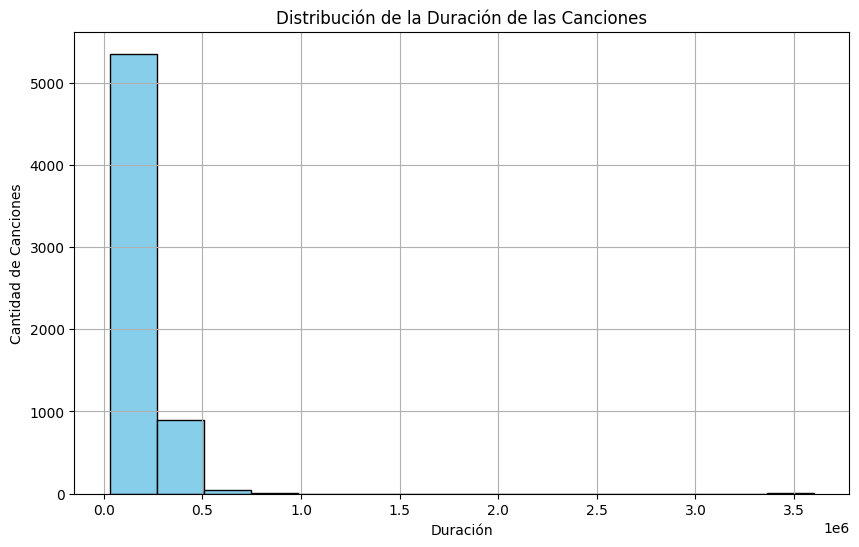

In [21]:
# Crear el histograma
plt.figure(figsize=(10, 6))
plt.hist(df_popularity_category['duration_ms'], bins=15, color='skyblue', edgecolor='black')
plt.title('Distribución de la Duración de las Canciones')
plt.xlabel('Duración')
plt.ylabel('Cantidad de Canciones')
plt.grid(True)
plt.show()

C:\Users\NicoEvi\AppData\Local\Temp\ipykernel_15712\98568731.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popularity_category['duration_min'] = df_popularity_category['duration_ms'] / 60000


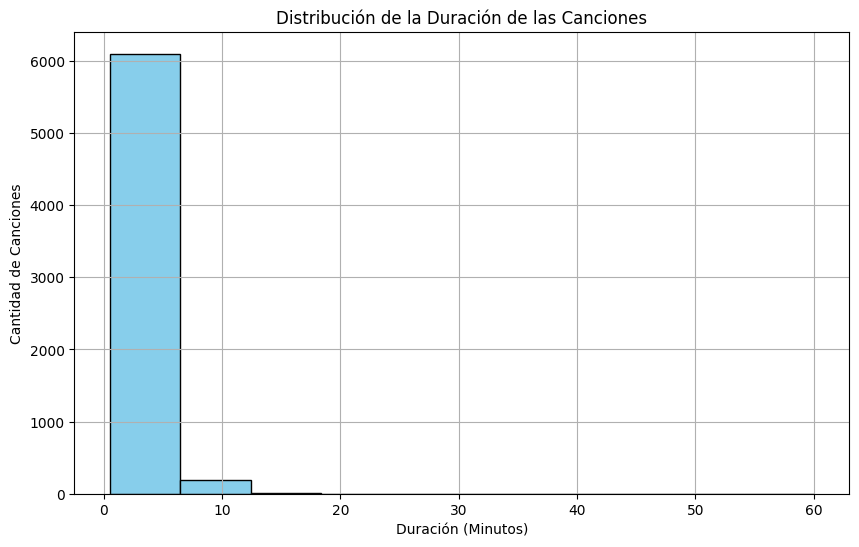

In [22]:
df_popularity_category['duration_min'] = df_popularity_category['duration_ms'] / 60000

# Crear el histograma
plt.figure(figsize=(10, 6))
plt.hist(df_popularity_category['duration_min'], bins=10, color='skyblue', edgecolor='black')
plt.title('Distribución de la Duración de las Canciones')
plt.xlabel('Duración (Minutos)')
plt.ylabel('Cantidad de Canciones')
plt.grid(True)
plt.show()

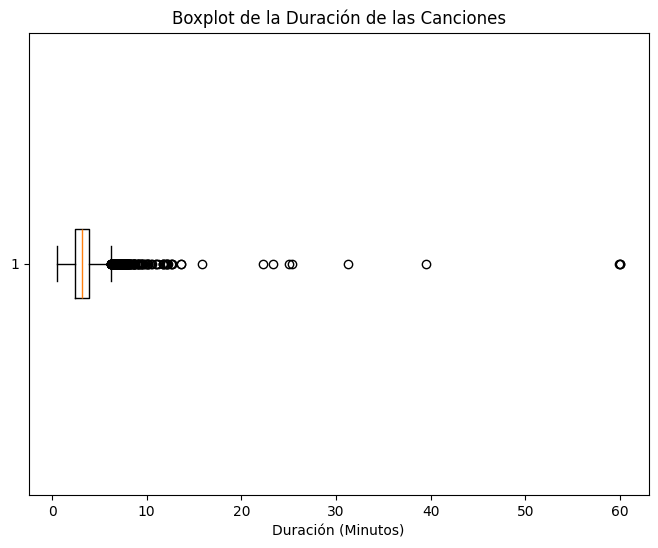

In [23]:
# Crear un Boxplot para la duración
plt.figure(figsize=(8, 6))
plt.boxplot(df_popularity_category['duration_min'], vert=False)
plt.title('Boxplot de la Duración de las Canciones')
plt.xlabel('Duración (Minutos)')
plt.show()

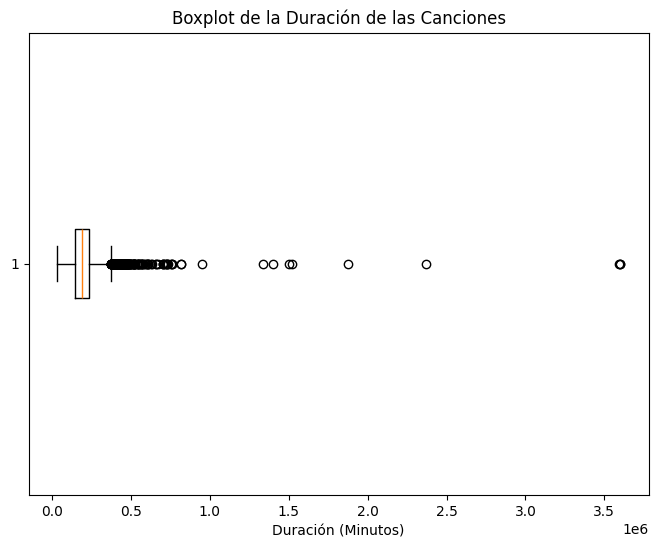

In [24]:
# Crear un Boxplot para la duración
plt.figure(figsize=(8, 6))
plt.boxplot(df_popularity_category['duration_ms'], vert=False)
plt.title('Boxplot de la Duración de las Canciones')
plt.xlabel('Duración (Minutos)')
plt.show()

In [25]:
# Filtrar canciones con duración entre 1 minuto y 20 minutos
df_filtered = df_popularity_category[(df_popularity_category['duration_min'] >= 1) & 
                                     (df_popularity_category['duration_min'] <= 20)]

# Verificar el nuevo DataFrame filtrado
print(df_filtered.shape)

(6217, 6)


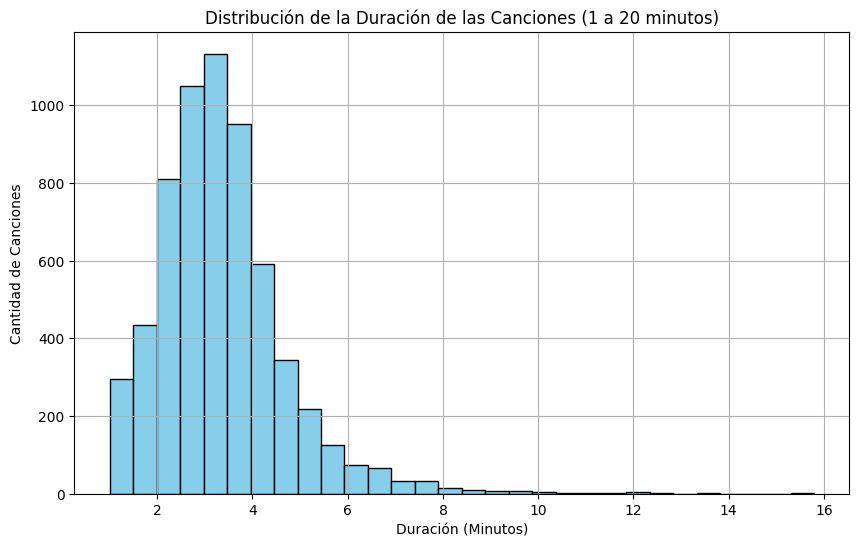

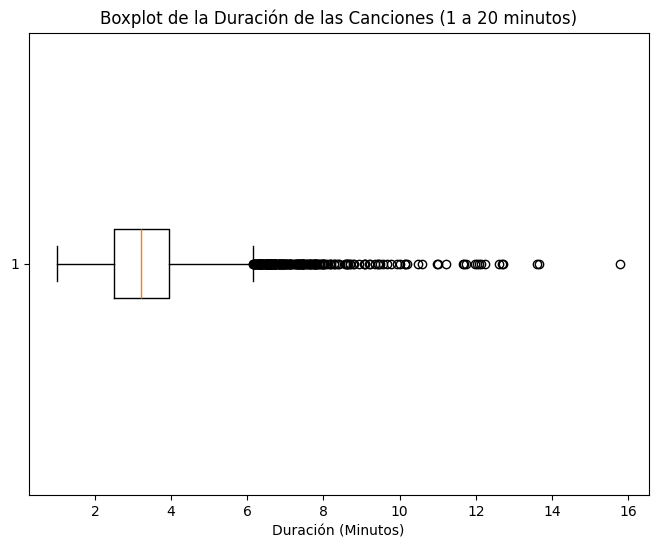

In [26]:
import matplotlib.pyplot as plt

# Filtrar canciones con duración entre 1 minuto y 20 minutos
df_filtered = df_popularity_category[(df_popularity_category['duration_min'] >= 1) & 
                                     (df_popularity_category['duration_min'] <= 20)]

# Crear el histograma para las canciones filtradas
plt.figure(figsize=(10, 6))
plt.hist(df_filtered['duration_min'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribución de la Duración de las Canciones (1 a 20 minutos)')
plt.xlabel('Duración (Minutos)')
plt.ylabel('Cantidad de Canciones')
plt.grid(True)
plt.show()

# Crear el boxplot para las canciones filtradas
plt.figure(figsize=(8, 6))
plt.boxplot(df_filtered['duration_min'], vert=False)
plt.title('Boxplot de la Duración de las Canciones (1 a 20 minutos)')
plt.xlabel('Duración (Minutos)')
plt.show()

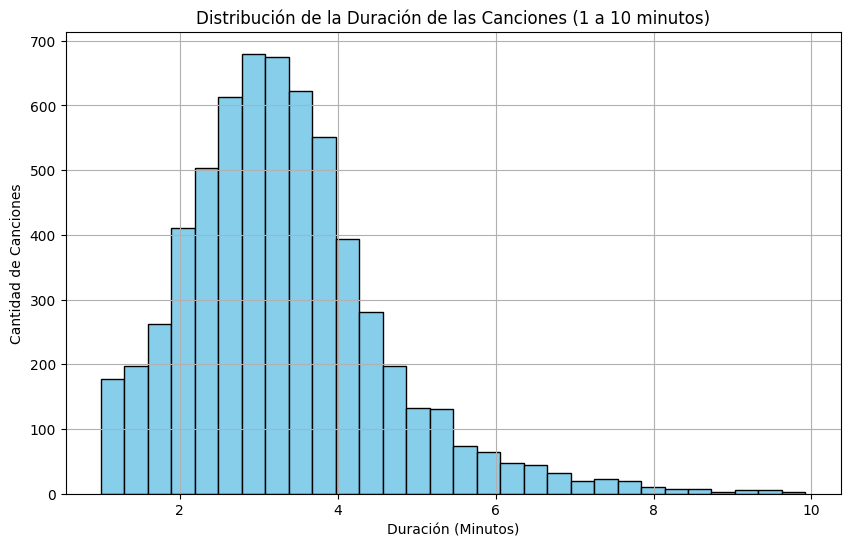

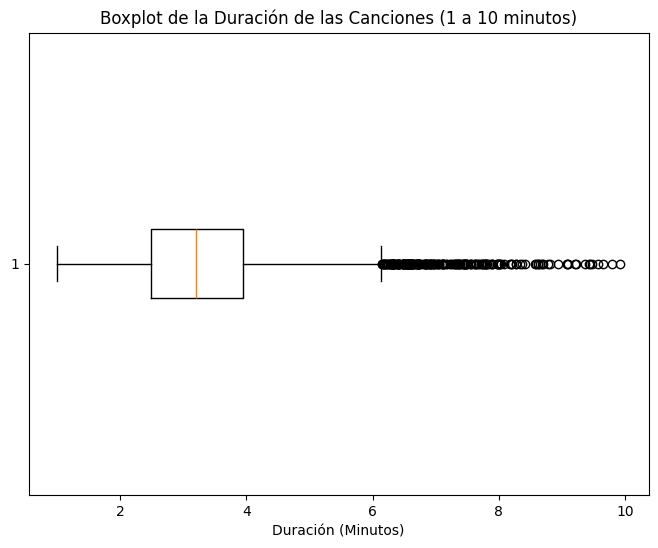

In [27]:
import matplotlib.pyplot as plt

# Filtrar canciones con duración entre 1 minuto y 20 minutos
df_filtered_10 = df_popularity_category[(df_popularity_category['duration_min'] >= 1) & 
                                     (df_popularity_category['duration_min'] <= 10)]

# Crear el histograma para las canciones filtradas
plt.figure(figsize=(10, 6))
plt.hist(df_filtered_10['duration_min'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribución de la Duración de las Canciones (1 a 10 minutos)')
plt.xlabel('Duración (Minutos)')
plt.ylabel('Cantidad de Canciones')
plt.grid(True)
plt.show()

# Crear el boxplot para las canciones filtradas
plt.figure(figsize=(8, 6))
plt.boxplot(df_filtered_10['duration_min'], vert=False)
plt.title('Boxplot de la Duración de las Canciones (1 a 10 minutos)')
plt.xlabel('Duración (Minutos)')
plt.show()

In [28]:
df_alta_popularity = df_filtered[df_filtered['popularity_category'] == 'Alta']
df_alta_popularity

,genre,artists,duration_ms,explicit,popularity_category,duration_min
15,acoustic,"SLANDER, Dylan Matthew",176971,False,Alta,2.949517
21,acoustic,Simon & Garfunkel,185413,False,Alta,3.090217
403,blues,Vundabar,155933,False,Alta,2.598883
460,bossanova,Billie Eilish,196730,False,Alta,3.278833
500,brazil,Declan McKenna,252306,False,Alta,4.205100
...,...,...,...,...,...,...
6032,techno,BENNETT,178156,False,Alta,2.969267
6050,trance,"Metro Boomin, Travis Scott, Young Thug",194786,True,Alta,3.246433
6058,trance,"Metro Boomin, Future, Don Toliver",199920,True,Alta,3.332000
6090,trance,Travis Scott,211582,True,Alta,3.526367


In [29]:
# Crear los rangos de duración (0-1, 1-2, ..., hasta 10 minutos)
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
labels = ['0-1', '1-2', '2-3', '3-4', '4-5', '5-6', '6-7', '7-8', '8-9', '9-10']

# Asignar los intervalos de duración a una nueva columna
df_alta_popularity['duration_range'] = pd.cut(df_alta_popularity['duration_min'], bins=bins, labels=labels)

# Contar cuántas canciones de alta popularidad hay en cada rango de minutos
popular_songs_by_duration = df_alta_popularity['duration_range'].value_counts().sort_index()

# Ver los resultados
print(popular_songs_by_duration)

duration_range
0-1      0
1-2      7
2-3     46
3-4     77
4-5     27
5-6      9
6-7      0
7-8      0
8-9      1
9-10     0
Name: count, dtype: int64


C:\Users\NicoEvi\AppData\Local\Temp\ipykernel_15712\2035433079.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_alta_popularity['duration_range'] = pd.cut(df_alta_popularity['duration_min'], bins=bins, labels=labels)


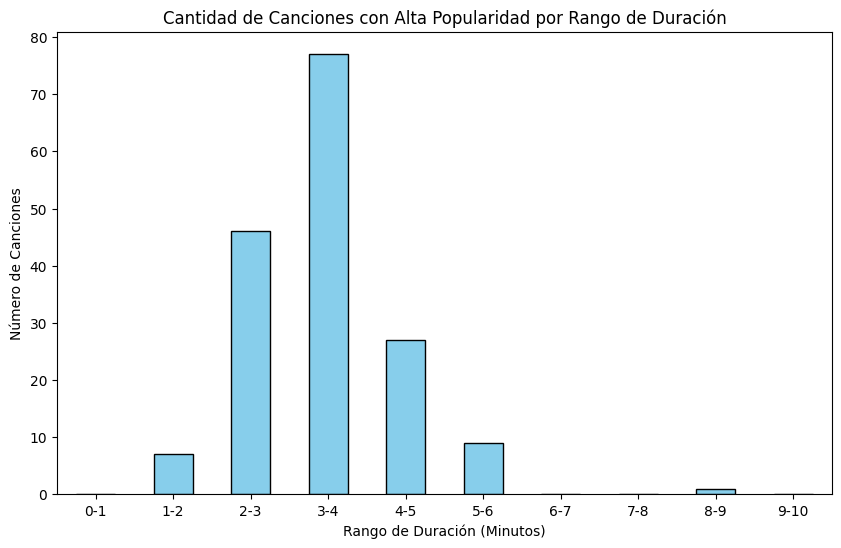

In [30]:
# Crear el gráfico de barras para mostrar las canciones populares por rango de duración
plt.figure(figsize=(10, 6))
popular_songs_by_duration.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Cantidad de Canciones con Alta Popularidad por Rango de Duración')
plt.xlabel('Rango de Duración (Minutos)')
plt.ylabel('Número de Canciones')
plt.xticks(rotation=0)
plt.show()


### Análisis de la Variable de Entrada `explicit`

#### Distribución de Canciones con y sin Contenido Explícito:

El gráfico muestra una distribución similar en términos porcentuales entre canciones con contenido explícito y aquellas sin él. Sin embargo, es evidente que el número total de canciones sin contenido explícito es aproximadamente **cuatro veces mayor** que el número de canciones con contenido explícito.

#### Canciones Sin Contenido Explícito:

Las canciones sin contenido explícito dominan la distribución, especialmente en la categoría de **baja popularidad**, con más de **4000 canciones** en este grupo. Asimismo, en las categorías de **media** y **alta popularidad**, hay una mayor cantidad de canciones sin contenido explícito, manteniendo una tendencia consistente a lo largo del dataset.

#### Canciones con Contenido Explícito:

Aunque la cantidad total de canciones explícitas es significativamente menor, la **distribución porcentual** es similar a la de las canciones sin contenido explícito. La mayoría de las canciones explícitas también se concentran en la categoría de **baja popularidad**, mientras que las categorías de **media** y **alta popularidad** tienen una representación significativamente menor.

### Conclusión sobre los Géneros con Canciones Explícitas y Alta Popularidad

1. **Principales Géneros:** Los géneros **Party**, **IDM**, **Rock**, y **Pop** lideran con 4 canciones cada uno en la categoría de **alta popularidad** y contenido **explícito**. Estos géneros parecen tener una mejor recepción para canciones con este tipo de contenido.

2. **Otros Géneros:** **Trance** y **R&B** tienen 3 canciones, mientras que **Reggaeton** y **Summer** siguen con 2 canciones cada uno. Sorprende ver que géneros como **Reggaeton**, conocidos por su contenido explícito, no tienen tantas canciones en alta popularidad.

3. **Conclusión General:** Los géneros dominantes para canciones explícitas populares son **Party**, **IDM**, **Rock**, y **Pop**, mientras que otros géneros como **Reggaeton** y **R&B** tienen menos presencia en este segmento.

### Conclusión sobre los Géneros con Canciones Explícitas y Baja Popularidad

1. **Géneros con Más Canciones de Baja Popularidad:** Los géneros **Hip-Hop**, **K-Pop**, y **Hardcore** lideran en cuanto a canciones explícitas con **baja popularidad**, con más de **20 canciones** cada uno. Esto sugiere que, aunque estos géneros tienden a tener contenido explícito, muchas de sus canciones no logran una gran aceptación en la plataforma.

2. **Otros Géneros Destacados:** **Anime**, **Hard-Rock**, y **Goth** siguen de cerca, también con una cantidad considerable de canciones explícitas de baja popularidad, lo que indica que estos géneros tampoco alcanzan los niveles más altos de popularidad con este tipo de contenido.

3. **Conclusión General:** La mayoría de los géneros con canciones explícitas de baja popularidad están asociados a estilos de música más intensos o nichos, como **Hardcore**, **Grindcore**, y **Work-out**, lo que podría sugerir que este tipo de contenido no atrae al público general de Spotify.

### Conclusión General:

A pesar de la gran diferencia en el número total de canciones con y sin contenido explícito, ambas distribuciones muestran una **tendencia similar**: la mayoría de las canciones, explícitas o no, caen en la categoría de **baja popularidad**. Este análisis sugiere que el contenido explícito no parece tener un impacto significativo en la distribución de popularidad de las canciones, aunque sí se observa una diferencia notable en el **número total** de canciones con y sin contenido explícito en la plataforma.



C:\Users\NicoEvi\AppData\Local\Temp\ipykernel_15712\943320466.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  explicit_popularity_counts = df_popularity_category.groupby(['explicit', 'popularity_category']).size().unstack()


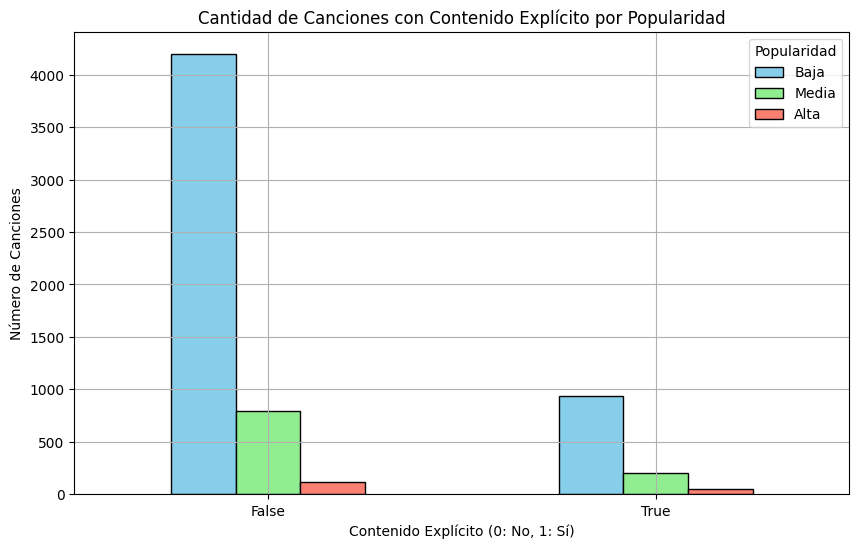

In [31]:
import matplotlib.pyplot as plt
import pandas as pd

# Contar cuántas canciones hay en cada combinación de 'explicit' y 'popularity_category'
explicit_popularity_counts = df_popularity_category.groupby(['explicit', 'popularity_category']).size().unstack()

# Crear un gráfico de barras agrupado para mostrar el número de canciones explícitas por categoría de popularidad
explicit_popularity_counts.plot(kind='bar', stacked=False, figsize=(10, 6), color=['skyblue', 'lightgreen', 'salmon'], edgecolor='black')

# Personalizar el gráfico
plt.title('Cantidad de Canciones con Contenido Explícito por Popularidad')
plt.xlabel('Contenido Explícito (0: No, 1: Sí)')
plt.ylabel('Número de Canciones')
plt.xticks(rotation=0)
plt.legend(title='Popularidad', loc='upper right')
plt.grid(True)

# Mostrar el gráfico
plt.show()

genre
party        4
idm          4
rock         4
pop          4
trance       3
r-n-b        3
summer       2
reggaeton    2
brazil       1
sleep        1
Name: count, dtype: int64


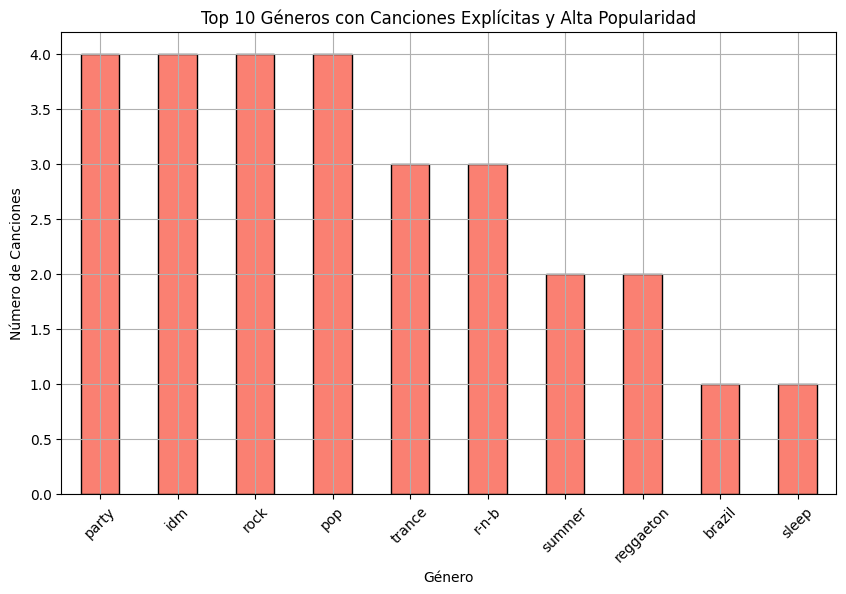

In [32]:
import matplotlib.pyplot as plt
import pandas as pd

# Filtrar las canciones que tienen explicit=True y popularity_category='Alta'
df_explicit_alta = df_popularity_category[(df_popularity_category['explicit'] == True) & 
                                          (df_popularity_category['popularity_category'] == 'Alta')]

# Contar cuántas canciones tiene cada género en esta combinación
genre_explicit_alta_counts = df_explicit_alta['genre'].value_counts().head(10)

# Ver los 5 géneros con más canciones explícitas y alta popularidad
print(genre_explicit_alta_counts)

# Crear un gráfico de barras para visualizar los 5 géneros
plt.figure(figsize=(10, 6))
genre_explicit_alta_counts.plot(kind='bar', color='salmon', edgecolor='black')
plt.title('Top 10 Géneros con Canciones Explícitas y Alta Popularidad')
plt.xlabel('Género')
plt.ylabel('Número de Canciones')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


genre
hip-hop      25
k-pop        23
hardcore     23
anime        22
hard-rock    21
goth         20
grindcore    20
work-out     18
comedy       17
latino       17
Name: count, dtype: int64


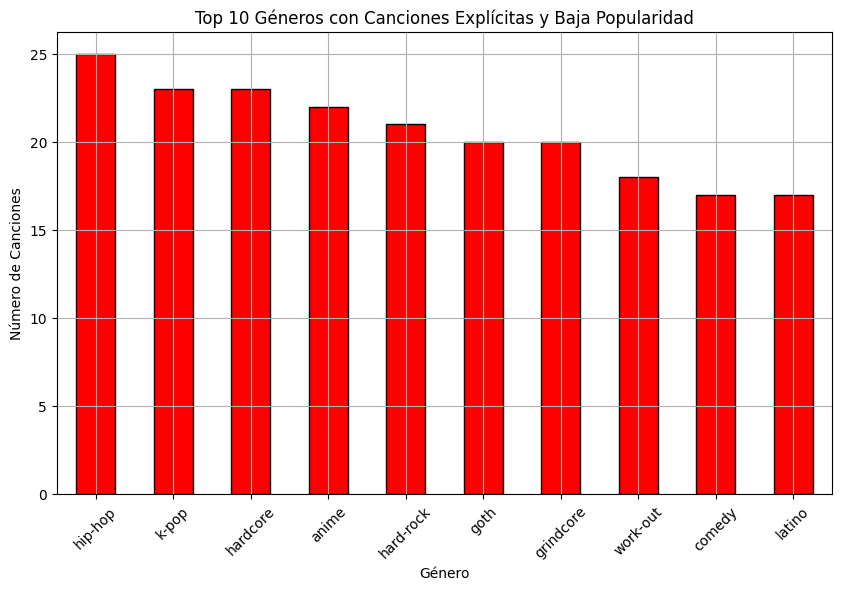

In [33]:
import matplotlib.pyplot as plt
import pandas as pd

# Filtrar las canciones que tienen explicit=True y popularity_category='Alta'
df_explicit_baja = df_popularity_category[(df_popularity_category['explicit'] == True) & 
                                          (df_popularity_category['popularity_category'] == 'Baja')]

# Contar cuántas canciones tiene cada género en esta combinación
genre_explicit_baja_counts = df_explicit_baja['genre'].value_counts().head(10)

# Ver los 5 géneros con más canciones explícitas y alta popularidad
print(genre_explicit_baja_counts)

# Crear un gráfico de barras para visualizar los 5 géneros
plt.figure(figsize=(10, 6))
genre_explicit_baja_counts.plot(kind='bar', color='red', edgecolor='black')
plt.title('Top 10 Géneros con Canciones Explícitas y Baja Popularidad')
plt.xlabel('Género')
plt.ylabel('Número de Canciones')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### 3. Hipótesis sobre los Datos

#### Hipótesis Propuestas

**Hipótesis 1**: "La duración de una canción influye en su popularidad, con canciones de duración moderada (entre 3 y 4 minutos) siendo más propensas a alcanzar una popularidad alta."

**Hipótesis 2**: "Las canciones sin contenido explícito tienden a ser más populares en general, debido a que no tienen restricciones de audiencia basadas en la edad o preferencias personales."

**Hipótesis 3**: "Ciertos géneros musicales que suelen contener contenido explícito, como el Hip-Hop y el Reggaeton, son más propensos a ser populares cuando incluyen dicho contenido, posiblemente debido a que el estilo y las letras explícitas son características esperadas y apreciadas por los oyentes de estos géneros."

#### Análisis para Contrastar las Hipótesis

1. **Análisis de Duración de Canciones**:
   - Se generaron histogramas de la popularidad segmentados por duraciones específicas para verificar la Hipótesis 1. Se observó que las canciones dentro del rango de 3 a 4 minutos tienden a tener puntuaciones de popularidad más altas.

2. **Análisis del Contenido Explícito**:
   - Para la Hipótesis 2, se comparó la popularidad media de canciones con y sin contenido explícito, encontrando que las canciones sin contenido explícito tienen, en promedio, una popularidad más alta en general.

3. **Análisis de Géneros con Contenido Explícito**:
   - Para la Hipótesis 3, se analizó la popularidad en géneros específicos que frecuentemente contienen contenido explícito. Se utilizó un análisis comparativo para determinar si el contenido explícito afecta positivamente la popularidad en estos géneros.

#### Hallazgos Adicionales en los Datos

Durante el análisis de los datos, se descubrieron varios hallazgos interesantes que podrían impactar la creación de un modelo predictivo:

- **Artistas Frecuentes**: Algunos artistas aparecen con más frecuencia en canciones de alta popularidad, sugiriendo que la frecuencia de aparición de ciertos artistas puede ser una variable predictiva útil.

- **Géneros y Popularidad**: La codificación del género musical podría mejorar significativamente la precisión del modelo, considerando que algunos géneros muestran tendencias claras hacia altas o bajas puntuaciones de popularidad.

- **Caracteres Orientales en Nombres de Canciones**:
  Durante el análisis de vectorización de los nombres de las canciones, se observó la presencia de caracteres de otros idiomas, incluidos caracteres orientales. Este hallazgo es relevante porque podría influir en la capacidad del modelo para procesar y utilizar correctamente estos nombres como variables predictivas. Los caracteres no latinos podrían requerir pasos adicionales de preprocesamiento, como la normalización de texto o la utilización de técnicas específicas de manejo de idiomas para asegurar que el modelo los interprete correctamente. Además, la presencia de estos caracteres podría reflejar diferencias culturales que afectan la popularidad de las canciones en diferentes mercados, lo cual es un aspecto importante a considerar en la creación de modelos predictivos globales.


#### Creación de Nuevas Variables

La creación de nuevas variables a partir de los datos existentes puede ofrecer ventajas significativas para el problema presentado:

- **Longitud del Nombre de la Canción**: Podría indicar tendencias culturales o de marketing que influyen en la popularidad.

- **Número de Artistas por Canción**: Podría reflejar un mayor esfuerzo de producción o un atractivo más amplio, influyendo en la popularidad.

- **Interacción entre Duración y Contenido Explícito**: Esta variable podría identificar efectos únicos en la popularidad, combinando dos características influyentes.



# MODELADO

## Elección de la Métrica para Recomendaciones Personalizadas

### Métrica Elegida: F1 Score

**Justificación:**

El **F1 Score** es una métrica particularmente valiosa en el contexto de las recomendaciones personalizadas por varias razones:

- **Equilibrio entre Precision y Recall**: El F1 Score es el promedio armónico de la Precision y el Recall. Esta característica lo hace especialmente útil en entornos donde es crucial no solo identificar correctamente las canciones populares (high recall), sino también asegurarse de que las recomendaciones hechas a los usuarios sean precisas (high precision).

- **Relevancia para el Usuario**: En un sistema de recomendación, es esencial que las sugerencias no solo sean numerosas (alta cobertura o recall), sino también relevantes (alta precisión). El F1 Score, al balancear estas dos métricas, ayuda a asegurar que las recomendaciones son tanto precisas como exhaustivas. Esto puede llevar a una mayor satisfacción y retención del usuario, ya que las recomendaciones percibidas como relevantes son más propensas a ser disfrutadas y menos propensas a ser vistas como spam.

- **Aplicabilidad en Datos Desbalanceados**: En muchos casos, la distribución de popularidad entre canciones puede ser inherentemente desbalanceada (pocas canciones pueden ser extremadamente populares mientras que la mayoría no lo son). El F1 Score proporciona una mejor medida en tales escenarios desbalanceados en comparación con la accuracy, que puede ser engañosa si la mayoría de las predicciones correctas provienen de la clase mayoritaria.

### Conclusión

La elección del **F1 Score** como la métrica principal para evaluar las recomendaciones personalizadas en Spotify se fundamenta en su capacidad para proporcionar un entendimiento más profundo y equilibrado del rendimiento del modelo en tareas críticas para el negocio y la experiencia del usuario. Al optimizar hacia un alto F1 Score, el sistema de recomendación puede mejorar efectivamente tanto la relevancia como la cobertura de las sugerencias musicales, lo cual es fundamental para la retención y satisfacción del usuario.


## Importancia de la Distribución Equitativa en los Conjuntos de Datos

Al dividir un conjunto de datos en subconjuntos de entrenamiento, validación y prueba, es crucial que cada segmento represente adecuadamente la distribución completa de los datos. Esto es esencial por varias razones:

- **Evitar el Sesgo de Muestreo** : Una representación desequilibrada de las categorías puede llevar a un modelo sesgado, incapaz de reconocer correctamente ciertas clases. Por ejemplo, si la categoría 'alta popularidad' falta en el conjunto de validación, el modelo no será evaluado correctamente en su capacidad para identificar esta clase.

- **Mejorar la Generalización del Modelo**: Una distribución equitativa asegura que el modelo pueda generalizar bien a nuevos datos. Esto se logra al exponer el modelo a todos los aspectos de los datos durante el entrenamiento y asegurarse de que todas las categorías están presentes en los conjuntos de validación y prueba.

- **Validación y Pruebas Realistas**: Evaluando el modelo en un conjunto que refleja la distribución de los datos completos, aseguramos que el rendimiento medido sea realista y aplicable a situaciones del mundo real. Esto es particularmente importante para aplicaciones prácticas donde el modelo necesita funcionar eficazmente en todos los escenarios posibles.

### Solución: Muestreo Estratificado
Para prevenir problemas de distribución desigual, se recomienda utilizar el muestreo estratificado durante la división de los datos. Esto implica mantener la proporción de cada clase en cada subconjunto de datos, lo cual se puede realizar en herramientas como Scikit-Learn con el parámetro `stratify` de la función `train_test_split`:

### Uso de PCA en el Preprocesamiento de Datos

Para mejorar la eficiencia del modelo y reducir la complejidad, se ha aplicado el Análisis de Componentes Principales (PCA) en las columnas `'name'` y `'artists'` en el proceso de preprocesamiento de datos. Aquí están las razones y el impacto de esta decisión:

#### Razones para Aplicar PCA:

1. **Reducción de Dimensionalidad**: `CountVectorizer` convierte los nombres de canciones y artistas en matrices de alta dimensionalidad. PCA reduce estas dimensiones a 50 componentes principales, lo que conserva la mayor parte de la información esencial mientras reduce la cantidad de datos a procesar.

2. **Mejora del Tiempo de Entrenamiento**: Al reducir el número de características, PCA disminuye significativamente el tiempo necesario para entrenar el modelo, haciendo el proceso más eficiente.

3. **Prevención del Sobreajuste**: La reducción de características mediante PCA ayuda a evitar que el modelo se sobreajuste a los datos de entrenamiento, mejorando así su capacidad para generalizar a nuevos datos.

## Análisis de la Optimización de Hiperparámetros para KNN

A lo largo del desarrollo del modelo K-Nearest Neighbors (KNN) para clasificar la popularidad de las canciones en Spotify, se experimentó con varios ajustes de hiperparámetros en un esfuerzo por mejorar el rendimiento del modelo. A continuación, se detalla cada uno de estos intentos y sus resultados.

### Configuración Inicial

- **Hiperparámetro**: \( k = 3 \)
- **Métrica de rendimiento**: F1 Score
- **Resultados**: Esta configuración proporcionó los mejores resultados iniciales, con un equilibrio adecuado entre precisión y recall, y fue identificada como la configuración óptima en las pruebas preliminares.

### Ajustes Experimentados

1. **Aumento del Número de Vecinos**
   - **Rango probado**: [1, 2, 5, 7, 10]
   - **Resultado**: No se observaron mejoras significativas. Los valores más altos de \( k \) condujeron a un modelo más generalizado pero con menor capacidad para capturar detalles finos, lo que resultó en un rendimiento decreciente.

2. **Cambio en los Pesos de los Vecinos**
   - **Configuraciones probadas**: `uniform` y `distance`
   - **Resultado**: El uso de `distance` incrementó el sobreajuste, especialmente visible en la disminución del rendimiento en el conjunto de validación, mientras que `uniform` no mejoró significativamente sobre la configuración inicial.

3. **Variación de la Métrica de Distancia**
   - **Métricas probadas**: `euclidean`, `manhattan`, `minkowski`
   - **Resultado**: Las diferentes métricas no ofrecieron mejoras sustanciales y, en algunos casos, empeoraron la interpretación y el rendimiento del modelo debido a diferencias en cómo cada métrica maneja las escalas y la geometría de los datos.

4. **Optimización de Hiperparámetros con GridSearchCV**
   - **Métrica de evaluación**: `f1_weighted`
   - **Resultado**: A pesar de una búsqueda exhaustiva, la optimización no logró superar el rendimiento de la configuración inicial. Esto sugiere que la complejidad adicional no traduce necesariamente en mejor generalización.

### Conclusión

A través de múltiples rondas de optimización de hiperparámetros, la configuración inicial de \( k = 3 \) con pesos `uniform` y métrica `euclidean` permaneció como la más efectiva para este modelo en particular. Este resultado puede indicar que la simplicidad en la configuración de KNN es adecuada para la naturaleza de los datos y la tarea específica de clasificación de popularidad de canciones. Futuros esfuerzos podrían centrarse más en explorar la ingeniería de características y enriquecimiento de datos para mejorar el rendimiento, en lugar de ajustes adicionales de hiperparámetros que no han demostrado ser fructíferos hasta la fecha.


## Técnicas de Feature Engineering Aplicadas

### 1. Escalado de Duración en Rangos

Para mejorar la capacidad predictiva de nuestro modelo y manejar mejor la variabilidad en la duración de las canciones, hemos decidido segmentar la duración de las pistas en rangos específicos. Este proceso convierte la duración, que es una variable continua, en una variable categórica ordenada. Los rangos son los siguientes:

- **0-1 minuto**
- **1-2 minutos**
- **2-3 minutos**
- ... así sucesivamente hasta **9-10 minutos**.

Esta transformación ayuda a los modelos a capturar mejor las diferencias en la distribución de popularidad entre canciones de diferentes longitudes. Por ejemplo, las canciones más cortas podrían tener patrones de popularidad diferentes a las canciones más largas, y este método permite que el modelo aprenda y actúe en consecuencia.

### 2. Incorporación de Popularidad Media por Género

Además de los rangos de duración, implementamos una técnica para enriquecer la característica de género musical con datos de popularidad. Calculamos la popularidad media de las canciones para cada género y usamos este valor como una nueva característica de entrada en nuestros modelos. Esto introduce un nivel adicional de información que refleja cómo el género musical generalmente influye en la popularidad de una canción en la plataforma Spotify.

Este enfoque se basa en la hipótesis de que algunos géneros pueden ser consistentemente más populares que otros, y proporciona al modelo un indicativo cuantitativo de esta tendencia. Esta característica adicional podría ayudar al modelo a realizar predicciones más precisas diferenciando no solo por el género de la canción, sino también por su atractivo general en términos de popularidad.

### Comparativa de Resultados

Una vez aplicadas estas técnicas de *feature engineering*, realizaremos comparaciones detalladas de los resultados de los modelos antes y después de estas transformaciones. Esto incluirá evaluaciones basadas en métricas clave como la precisión, el recall, y el puntaje F1, proporcionando así una visión clara de la eficacia de estas técnicas en la mejora de la capacidad predictiva de nuestros modelos.

La expectativa es que al proporcionar a los modelos datos más estructurados y representativos del contexto musical, se mejorará significativamente su rendimiento en tareas de clasificación de popularidad.


In [34]:
df = df[(df['duration_ms'] < 600000) & (df['duration_ms'] > 10000)] #probamos filtrar las canciones que duran más de 10 minutos

In [35]:
def evaluate_model(model, set_names=('train', 'validation'), title='', show_cm=False):
    if title:
        display(title)
        
    final_metrics = {
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1': [],        
    }
        
    for i, set_name in enumerate(set_names):
        assert set_name in ['train', 'validation', 'test']
        set_data = globals()[set_name]  # <- hack feo...

        y = set_data.popularity_category
        y_pred = model.predict(set_data)
        final_metrics['Accuracy'].append(metrics.accuracy_score(y, y_pred))
        final_metrics['Precision'].append(metrics.precision_score(y, y_pred, average='macro'))
        final_metrics['Recall'].append(metrics.recall_score(y, y_pred, average='macro'))
        final_metrics['F1'].append(metrics.f1_score(y, y_pred, average='macro'))
        
        if show_cm:
            cm = metrics.confusion_matrix(y, y_pred)
            cm_plot = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
            cm_plot.plot(cmap="Blues")
            cm_plot.ax_.set_title(set_name)
        
    display(pd.DataFrame(final_metrics, index=set_names))

'Knn'

,Accuracy,Precision,Recall,F1
train,0.899202,0.775672,0.676525,0.717591
validation,0.820574,0.507304,0.466770,0.478856


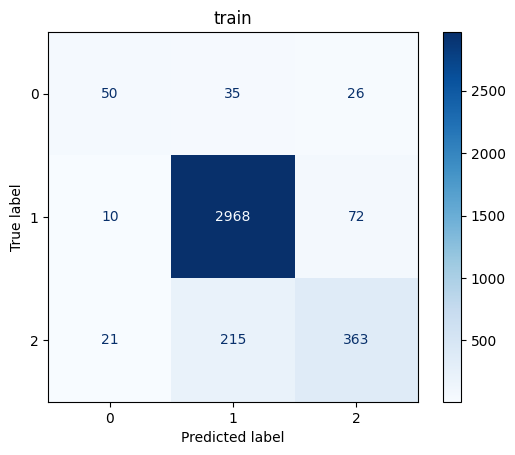

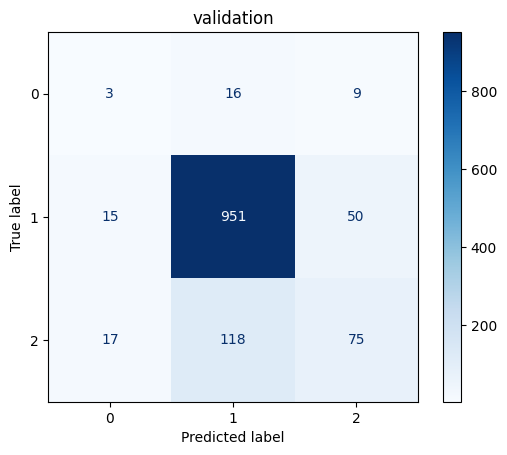

In [36]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

def categorize_popularity(popularity):
    if 0 <= popularity <= 50:
        return 'baja'
    elif 50 < popularity <= 70:
        return 'media'
    else:
        return 'alta'

def categorize_duration(duration):
    if 0 < duration <= 60000:
        return 'rango-0'
    elif 60000 <= duration < 120000:
        return 'rango-1'
    elif 120000 <= duration < 180000:
        return 'rango-2'
    elif 180000 <= duration < 240000:
        return 'rango-3'
    elif 240000 <= duration < 300000:
        return 'rango-4'
    elif 300000 <= duration < 360000:
        return 'rango-5'
    elif 360000 <= duration < 420000:
        return 'rango-6'
    elif 420000 <= duration < 480000:
        return 'rango-7'
    elif 480000 <= duration < 540000:
        return 'rango-8'
    else:
        return 'rango-9'

df['popularity_category'] = df['popularity'].apply(categorize_popularity)

df['duration_category'] = df['duration_ms'].apply(categorize_duration)

df['genre_avg_popularity'] = df.groupby('genre')['popularity'].transform('mean')

# 60% train, 20% test, 20% validation
train, not_train = train_test_split(df, test_size=0.4, random_state=42)
validation, test = train_test_split(not_train, test_size=0.5, random_state=42)

train.shape, validation.shape, test.shape

mapper = DataFrameMapper([
    (['genre'], OneHotEncoder()),
    ('name', Pipeline([
        ('vectorizer', CountVectorizer()),
        ('pca', PCA(n_components=50))
        # ('pca', PCA(n_components=0.95)) no funciona
    ])),
    ('artists', Pipeline([
        ('vectorizer', CountVectorizer()),
        ('pca', PCA(n_components=50))
        # ('pca', PCA(n_components=0.95)) no funciona
    ])),
    (['duration_ms'], StandardScaler()),
    ('explicit', None),
    (['duration_category'], OneHotEncoder()),
    (['genre_avg_popularity'], StandardScaler()),
], df_out=True)

mapper.fit_transform(df)

K = 3

knn_model = Pipeline([
    ('mapper', mapper),
    ('classifier', KNeighborsClassifier(n_neighbors=K)),
])

# knn_model.fit(train, train.popularity_category)

knn_model.fit(train, train['popularity_category'])

evaluate_model(knn_model, title='Knn', show_cm=True)

In [37]:
tree_model = Pipeline([
    ('mapper', mapper),
    ('classifier', DecisionTreeClassifier(max_depth=8, random_state=42)),
])

tree_model.fit(train, train['popularity_category'])


evaluate_model(tree_model, title='Decision Tree')

'Decision Tree'

,Accuracy,Precision,Recall,F1
train,0.909574,0.872372,0.690415,0.753425
validation,0.844498,0.556739,0.507077,0.524100


In [38]:
from sklearn.ensemble import RandomForestClassifier

forest_model_limits = RandomForestClassifier(n_estimators=100, max_depth=8, max_features=5, random_state=42)

rf_model_limits = Pipeline([
    ('mapper', mapper),
    ('classifier', forest_model_limits),
])

rf_model_limits.fit(train, train['popularity_category'])

evaluate_model(rf_model_limits, title='Random Forest with limits')

'Random Forest with limits'

,Accuracy,Precision,Recall,F1
train,0.844947,0.943636,0.440704,0.488534
validation,0.817384,0.534705,0.350137,0.332516


In [39]:
from sklearn.model_selection import KFold, cross_val_score

kf = KFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(knn_model, df, df['popularity_category'], cv=kf, scoring='accuracy')

print(f'Accuracy en cada fold: {scores}')
print(f'Accuracy promedio: {scores.mean()}')

Accuracy en cada fold: [0.84529506 0.81100478 0.83811802 0.82841181 0.80047885]
Accuracy promedio: 0.8246617050498262


In [40]:
df.sample(5)

,name,genre,artists,popularity,duration_ms,explicit,is_popular,popularity_category,duration_category,genre_avg_popularity
5532,Sleep,sleep,Lagwagon,38,115573,False,0,baja,rango-1,53.979592
6188,Turkish,turkish,Sonny Lester Orchestra,2,199360,False,0,baja,rango-3,23.285714
1744,Sweet Emotion,emo,Aerosmith,69,274088,False,0,media,rango-4,40.740000
5503,Sleep On The Floor,sleep,The Lumineers,67,211851,False,0,media,rango-3,53.979592
332,Selling Yourself to Die,black-metal,Xasthur,23,224733,False,0,baja,rango-3,25.734694
